In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import joblib
from scipy import stats
import argparse
import keras_tuner as kt


## Functions

In [19]:
df1 = pd.read_csv("./data/30_2019/task_report.csv")
df2 = pd.read_excel("./data/New_Dummy/Project Dummy Data.xlsx", sheet_name="Task_Table1") 

df_IL1 = pd.read_excel("./data/New_Dummy/Project Dummy Data - Progressive.xlsx", sheet_name="Progress 0")
df_IL2 = pd.read_excel("./data/New_Dummy/Project Dummy Data - Progressive.xlsx", sheet_name="Progress 35%")
df_IL3 = pd.read_excel("./data/New_Dummy/Project Dummy Data - Progressive.xlsx", sheet_name="Progress 50%")
df_IL4 = pd.read_excel("./data/New_Dummy/Project Dummy Data - Progressive.xlsx", sheet_name="Progress 75%")
df_IL5 = pd.read_excel("./data/New_Dummy/Project Dummy Data - Progressive.xlsx", sheet_name="Progress 100%")



def isWeekend(date):
    return date.weekday() >= 5

def preprocess_project(df):

    df['StartDate'] = pd.to_datetime(df['StartDate'])
    df['EndDate'] = pd.to_datetime(df['EndDate'])
    df['ActualStartDate'] = pd.to_datetime(df['ActualStartDate'])
    df['ActualEndDate'] = pd.to_datetime(df['ActualEndDate'])

    df['Trade'] = LabelEncoder().fit_transform(df['Trade'])

    # df['Delay'] = (df['ActualEndDate'] - df['EndDate']).dt.days
    return df

def preprocess_project2(df):
    df['Trade'] = LabelEncoder().fit_transform(df['Trade'])
    df = df.iloc[1: , :]

    df['Duration'] = df['Duration'].astype('int32')
    df['Delay'] = df['Delay'].astype('int32')
    df['Trade'] = df['Trade'].astype('int32')
    df['Progress'] = df['Progress'].astype('float32')
    df['Worker_Score'] = pd.to_numeric(df['Worker_Score'], errors='coerce')
    df['Temp'] = pd.to_numeric(df['Temp'], errors='coerce')
    df['Rain_Probability'] = pd.to_numeric(df['Rain_Probability'], errors='coerce')
    df['Wind_Speed'] = pd.to_numeric(df['Wind_Speed'], errors='coerce')

    df = df.rename(columns={"Rain_Probability" : "RainProb", "Temp": "Temperature", "Wind_Speed": "WindSpeed", "Worker_Score":"WorkerScore"})

    return df

In [33]:


def train_model(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the parameter grid XGBOOST
    # param_grid = {
    #     'max_depth': [3, 5, 7, 9, 11],
    #     'learning_rate': [0.01, 0.1, 0.2, 0.3],
    #     'n_estimators': [100, 200, 300]
    # }

    # Define the parameter grid for RandomForestRegressor
    # param_grid = {
    #     'n_estimators': [50, 100, 150],
    #     'max_depth': [3, 5, 7, 9, 11],
    #     'min_samples_split': [2, 5, 10],
    #     'min_samples_leaf': [1, 2, 4]
    # }

   # Define the parameter grid for DecisionTreeRegressor
    param_grid = {
        'max_depth': [3, 5, 7, 9, 11],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Perform grid search
    grid_search = GridSearchCV(estimator=RandomForestRegressor(),
                               param_grid=param_grid,
                               cv=3,
                               scoring='neg_mean_absolute_error',
                               n_jobs=-1)

    grid_search.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_

    y_val_pred = best_model.predict(X_test)
    y_train_pred = best_model.predict(X_train)

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_val = mean_absolute_error(y_test, y_val_pred)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)

    print(f"MAE Train: {mae_train}, MAE Validation: {mae_val}")
    print(f"RMSE: {rmse_train}, R2: {r2_train}")
    
    explainer = shap.Explainer(best_model, feature_names=X.columns)

    # Save the best model
    joblib.dump(best_model, './model/30_2019_v6_XGB.pkl')
    
    return best_model, explainer, mae_train, mae_val


processed_df = preprocess_project(df2)
train_df = processed_df.drop(columns=['ID', 'Outline_Number','Name','StartDate','EndDate', 'Predecessors', 'Successors', 'ActualStartDate','ActualEndDate'])

# print(train_df.columns)

model, explainer, mae_train, mae_val = train_model(train_df, 'Delay')

MAE Train: 1.094199727345856, MAE Validation: 1.134259996924446
RMSE: 1.3562110984669102, R2: 0.14320785266527103


## MLP

Feature Variance:
 Duration       1288.551769
Trade           109.019729
Progress        873.260154
WorkerScore     688.465977
Temperature      56.285111
RainProb        880.706798
WindSpeed       290.957009
dtype: float64
Reloading Tuner from my_dir\MLP_tuning\tuner0.json
38/38 [==============================] - 0s 568us/step
MAE Train: 0.9665191335325054, MAE Validation: 1.1976519071310758
RMSE: 1.3750573380442142, R2: 0.11923001680941059
4/4 [==============================] - 0s 761us/step


  0%|          | 0/300 [00:00<?, ?it/s]

313/313 [==============================] - 0s 494us/step


  0%|          | 1/300 [00:00<01:35,  3.15it/s]

313/313 [==============================] - 0s 510us/step


  1%|          | 2/300 [00:00<01:36,  3.09it/s]

313/313 [==============================] - 0s 478us/step


  1%|          | 3/300 [00:00<01:35,  3.10it/s]

313/313 [==============================] - 0s 517us/step


  1%|▏         | 4/300 [00:01<01:37,  3.02it/s]

313/313 [==============================] - 0s 497us/step


  2%|▏         | 5/300 [00:01<01:36,  3.04it/s]

313/313 [==============================] - 0s 532us/step


  2%|▏         | 6/300 [00:01<01:37,  3.02it/s]

313/313 [==============================] - 0s 487us/step


  2%|▏         | 7/300 [00:02<01:35,  3.05it/s]

313/313 [==============================] - 0s 495us/step


  3%|▎         | 8/300 [00:02<01:35,  3.06it/s]

313/313 [==============================] - 0s 494us/step


  3%|▎         | 9/300 [00:02<01:34,  3.08it/s]

313/313 [==============================] - 0s 481us/step


  3%|▎         | 10/300 [00:03<01:33,  3.09it/s]

313/313 [==============================] - 0s 496us/step


  4%|▎         | 11/300 [00:03<01:33,  3.08it/s]

313/313 [==============================] - 0s 503us/step


  4%|▍         | 12/300 [00:03<01:33,  3.08it/s]

313/313 [==============================] - 0s 508us/step


  4%|▍         | 13/300 [00:04<01:33,  3.06it/s]

313/313 [==============================] - 0s 478us/step


  5%|▍         | 14/300 [00:04<01:32,  3.08it/s]

313/313 [==============================] - 0s 499us/step


  5%|▌         | 15/300 [00:04<01:32,  3.08it/s]

313/313 [==============================] - 0s 557us/step


  5%|▌         | 16/300 [00:05<01:34,  3.02it/s]

313/313 [==============================] - 0s 509us/step


  6%|▌         | 17/300 [00:05<01:33,  3.03it/s]

313/313 [==============================] - 0s 507us/step


  6%|▌         | 18/300 [00:05<01:32,  3.04it/s]

313/313 [==============================] - 0s 486us/step


  6%|▋         | 19/300 [00:06<01:32,  3.04it/s]

313/313 [==============================] - 0s 478us/step


  7%|▋         | 20/300 [00:06<01:31,  3.06it/s]

313/313 [==============================] - 0s 495us/step


  7%|▋         | 21/300 [00:06<01:30,  3.07it/s]

313/313 [==============================] - 0s 490us/step


  7%|▋         | 22/300 [00:07<01:30,  3.07it/s]

313/313 [==============================] - 0s 487us/step


  8%|▊         | 23/300 [00:07<01:29,  3.08it/s]

313/313 [==============================] - 0s 484us/step


  8%|▊         | 24/300 [00:07<01:29,  3.09it/s]

313/313 [==============================] - 0s 481us/step


  8%|▊         | 25/300 [00:08<01:28,  3.10it/s]

313/313 [==============================] - 0s 513us/step


  9%|▊         | 26/300 [00:08<01:29,  3.05it/s]

313/313 [==============================] - 0s 490us/step


  9%|▉         | 27/300 [00:08<01:29,  3.06it/s]

313/313 [==============================] - 0s 499us/step


  9%|▉         | 28/300 [00:09<01:29,  3.06it/s]

313/313 [==============================] - 0s 504us/step


 10%|▉         | 29/300 [00:09<01:28,  3.06it/s]

313/313 [==============================] - 0s 504us/step


 10%|█         | 30/300 [00:09<01:28,  3.05it/s]

313/313 [==============================] - 0s 497us/step


 10%|█         | 31/300 [00:10<01:27,  3.06it/s]

313/313 [==============================] - 0s 478us/step


 11%|█         | 32/300 [00:10<01:27,  3.07it/s]

313/313 [==============================] - 0s 484us/step


 11%|█         | 33/300 [00:10<01:26,  3.08it/s]

313/313 [==============================] - 0s 525us/step


 11%|█▏        | 34/300 [00:11<01:27,  3.05it/s]

313/313 [==============================] - 0s 503us/step


 12%|█▏        | 35/300 [00:11<01:27,  3.01it/s]

313/313 [==============================] - 0s 500us/step


 12%|█▏        | 36/300 [00:11<01:27,  3.03it/s]

313/313 [==============================] - 0s 533us/step


 12%|█▏        | 37/300 [00:12<01:27,  3.00it/s]

313/313 [==============================] - 0s 498us/step


 13%|█▎        | 38/300 [00:12<01:26,  3.02it/s]

313/313 [==============================] - 0s 487us/step


 13%|█▎        | 39/300 [00:12<01:26,  3.03it/s]

313/313 [==============================] - 0s 506us/step


 13%|█▎        | 40/300 [00:13<01:25,  3.04it/s]

313/313 [==============================] - 0s 500us/step


 14%|█▎        | 41/300 [00:13<01:24,  3.05it/s]

313/313 [==============================] - 0s 517us/step


 14%|█▍        | 42/300 [00:13<01:24,  3.04it/s]

313/313 [==============================] - 0s 513us/step


 14%|█▍        | 43/300 [00:14<01:24,  3.03it/s]

313/313 [==============================] - 0s 490us/step


 15%|█▍        | 44/300 [00:14<01:23,  3.05it/s]

313/313 [==============================] - 0s 577us/step


 15%|█▌        | 45/300 [00:14<01:25,  2.98it/s]

313/313 [==============================] - 0s 527us/step


 15%|█▌        | 46/300 [00:15<01:25,  2.97it/s]

313/313 [==============================] - 0s 500us/step


 16%|█▌        | 47/300 [00:15<01:24,  2.99it/s]

313/313 [==============================] - 0s 513us/step


 16%|█▌        | 48/300 [00:15<01:24,  2.99it/s]

313/313 [==============================] - 0s 519us/step


 16%|█▋        | 49/300 [00:16<01:24,  2.98it/s]

313/313 [==============================] - 0s 506us/step


 17%|█▋        | 50/300 [00:16<01:23,  2.99it/s]

313/313 [==============================] - 0s 491us/step


 17%|█▋        | 51/300 [00:16<01:22,  3.01it/s]

313/313 [==============================] - 0s 506us/step


 17%|█▋        | 52/300 [00:17<01:22,  3.02it/s]

313/313 [==============================] - 0s 524us/step


 18%|█▊        | 53/300 [00:17<01:21,  3.02it/s]

313/313 [==============================] - 0s 510us/step


 18%|█▊        | 54/300 [00:17<01:21,  3.01it/s]

313/313 [==============================] - 0s 552us/step


 18%|█▊        | 55/300 [00:18<01:22,  2.97it/s]

313/313 [==============================] - 0s 513us/step


 19%|█▊        | 56/300 [00:18<01:21,  2.98it/s]

313/313 [==============================] - 0s 520us/step


 19%|█▉        | 57/300 [00:18<01:21,  2.98it/s]

313/313 [==============================] - 0s 588us/step


 19%|█▉        | 58/300 [00:19<01:23,  2.89it/s]

313/313 [==============================] - 0s 492us/step


 20%|█▉        | 59/300 [00:19<01:22,  2.93it/s]

313/313 [==============================] - 0s 497us/step


 20%|██        | 60/300 [00:19<01:21,  2.96it/s]

313/313 [==============================] - 0s 583us/step


 20%|██        | 61/300 [00:20<01:25,  2.80it/s]

313/313 [==============================] - 0s 558us/step


 21%|██        | 62/300 [00:20<01:26,  2.74it/s]

313/313 [==============================] - 0s 635us/step


 21%|██        | 63/300 [00:20<01:29,  2.65it/s]

313/313 [==============================] - 0s 715us/step


 21%|██▏       | 64/300 [00:21<01:33,  2.52it/s]

313/313 [==============================] - 0s 558us/step


 22%|██▏       | 65/300 [00:21<01:31,  2.58it/s]

313/313 [==============================] - 0s 545us/step


 22%|██▏       | 66/300 [00:22<01:28,  2.63it/s]

313/313 [==============================] - 0s 510us/step


 22%|██▏       | 67/300 [00:22<01:26,  2.70it/s]

313/313 [==============================] - 0s 523us/step


 23%|██▎       | 68/300 [00:22<01:23,  2.78it/s]

313/313 [==============================] - 0s 619us/step


 23%|██▎       | 69/300 [00:23<01:24,  2.72it/s]

313/313 [==============================] - 0s 545us/step


 23%|██▎       | 70/300 [00:23<01:24,  2.73it/s]

313/313 [==============================] - 0s 558us/step


 24%|██▎       | 71/300 [00:23<01:24,  2.73it/s]

313/313 [==============================] - 0s 620us/step


 24%|██▍       | 72/300 [00:24<01:24,  2.70it/s]

313/313 [==============================] - 0s 542us/step


 24%|██▍       | 73/300 [00:24<01:22,  2.76it/s]

313/313 [==============================] - 0s 513us/step


 25%|██▍       | 74/300 [00:25<01:20,  2.80it/s]

313/313 [==============================] - 0s 520us/step


 25%|██▌       | 75/300 [00:25<01:18,  2.85it/s]

313/313 [==============================] - 0s 518us/step


 25%|██▌       | 76/300 [00:25<01:17,  2.88it/s]

313/313 [==============================] - 0s 529us/step


 26%|██▌       | 77/300 [00:26<01:16,  2.90it/s]

313/313 [==============================] - 0s 494us/step


 26%|██▌       | 78/300 [00:26<01:15,  2.96it/s]

313/313 [==============================] - 0s 500us/step


 26%|██▋       | 79/300 [00:26<01:14,  2.98it/s]

313/313 [==============================] - 0s 513us/step


 27%|██▋       | 80/300 [00:27<01:13,  2.99it/s]

313/313 [==============================] - 0s 511us/step


 27%|██▋       | 81/300 [00:27<01:13,  3.00it/s]

313/313 [==============================] - 0s 554us/step


 27%|██▋       | 82/300 [00:27<01:15,  2.89it/s]

313/313 [==============================] - 0s 502us/step


 28%|██▊       | 83/300 [00:28<01:14,  2.93it/s]

313/313 [==============================] - 0s 499us/step


 28%|██▊       | 84/300 [00:28<01:12,  2.97it/s]

313/313 [==============================] - 0s 500us/step


 28%|██▊       | 85/300 [00:28<01:11,  2.99it/s]

313/313 [==============================] - 0s 507us/step


 29%|██▊       | 86/300 [00:29<01:11,  3.00it/s]

313/313 [==============================] - 0s 500us/step


 29%|██▉       | 87/300 [00:29<01:10,  3.01it/s]

313/313 [==============================] - 0s 504us/step


 29%|██▉       | 88/300 [00:29<01:10,  3.02it/s]

313/313 [==============================] - 0s 513us/step


 30%|██▉       | 89/300 [00:30<01:10,  3.01it/s]

313/313 [==============================] - 0s 520us/step


 30%|███       | 90/300 [00:30<01:10,  2.99it/s]

313/313 [==============================] - 0s 494us/step


 30%|███       | 91/300 [00:30<01:09,  3.01it/s]

313/313 [==============================] - 0s 555us/step


 31%|███       | 92/300 [00:31<01:10,  2.96it/s]

313/313 [==============================] - 0s 529us/step


 31%|███       | 93/300 [00:31<01:09,  2.96it/s]

313/313 [==============================] - 0s 502us/step


 31%|███▏      | 94/300 [00:31<01:09,  2.98it/s]

313/313 [==============================] - 0s 519us/step


 32%|███▏      | 95/300 [00:32<01:08,  2.98it/s]

313/313 [==============================] - 0s 538us/step


 32%|███▏      | 96/300 [00:32<01:08,  2.96it/s]

313/313 [==============================] - 0s 523us/step


 32%|███▏      | 97/300 [00:32<01:08,  2.96it/s]

313/313 [==============================] - 0s 506us/step


 33%|███▎      | 98/300 [00:33<01:08,  2.96it/s]

313/313 [==============================] - 0s 508us/step


 33%|███▎      | 99/300 [00:33<01:07,  2.96it/s]

313/313 [==============================] - 0s 510us/step


 33%|███▎      | 100/300 [00:33<01:07,  2.98it/s]

313/313 [==============================] - 0s 494us/step


 34%|███▎      | 101/300 [00:34<01:05,  3.02it/s]

313/313 [==============================] - 0s 529us/step


 34%|███▍      | 102/300 [00:34<01:36,  2.05it/s]

313/313 [==============================] - 0s 506us/step


 34%|███▍      | 103/300 [00:35<01:26,  2.27it/s]

313/313 [==============================] - 0s 501us/step


 35%|███▍      | 104/300 [00:35<01:19,  2.46it/s]

313/313 [==============================] - 0s 503us/step


 35%|███▌      | 105/300 [00:35<01:15,  2.60it/s]

313/313 [==============================] - 0s 520us/step


 35%|███▌      | 106/300 [00:36<01:11,  2.71it/s]

313/313 [==============================] - 0s 541us/step


 36%|███▌      | 107/300 [00:36<01:10,  2.73it/s]

313/313 [==============================] - 0s 515us/step


 36%|███▌      | 108/300 [00:36<01:08,  2.80it/s]

313/313 [==============================] - 0s 522us/step


 36%|███▋      | 109/300 [00:37<01:07,  2.84it/s]

313/313 [==============================] - 0s 514us/step


 37%|███▋      | 110/300 [00:37<01:06,  2.87it/s]

313/313 [==============================] - 0s 531us/step


 37%|███▋      | 111/300 [00:37<01:05,  2.90it/s]

313/313 [==============================] - 0s 516us/step


 37%|███▋      | 112/300 [00:38<01:04,  2.92it/s]

313/313 [==============================] - 0s 510us/step


 38%|███▊      | 113/300 [00:38<01:03,  2.93it/s]

313/313 [==============================] - 0s 513us/step


 38%|███▊      | 114/300 [00:38<01:03,  2.95it/s]

313/313 [==============================] - 0s 518us/step


 38%|███▊      | 115/300 [00:39<01:02,  2.96it/s]

313/313 [==============================] - 0s 513us/step


 39%|███▊      | 116/300 [00:39<01:01,  2.98it/s]

313/313 [==============================] - 0s 564us/step


 39%|███▉      | 117/300 [00:39<01:02,  2.92it/s]

313/313 [==============================] - 0s 506us/step


 39%|███▉      | 118/300 [00:40<01:01,  2.95it/s]

313/313 [==============================] - 0s 505us/step


 40%|███▉      | 119/300 [00:40<01:00,  2.97it/s]

313/313 [==============================] - 0s 536us/step


 40%|████      | 120/300 [00:40<01:00,  2.95it/s]

313/313 [==============================] - 0s 510us/step


 40%|████      | 121/300 [00:41<01:00,  2.98it/s]

313/313 [==============================] - 0s 517us/step


 41%|████      | 122/300 [00:41<00:59,  2.99it/s]

313/313 [==============================] - 0s 504us/step


 41%|████      | 123/300 [00:41<00:59,  3.00it/s]

313/313 [==============================] - 0s 505us/step


 41%|████▏     | 124/300 [00:42<00:58,  3.00it/s]

313/313 [==============================] - 0s 526us/step


 42%|████▏     | 125/300 [00:42<00:58,  3.00it/s]

313/313 [==============================] - 0s 507us/step


 42%|████▏     | 126/300 [00:42<00:57,  3.01it/s]

313/313 [==============================] - 0s 580us/step


 42%|████▏     | 127/300 [00:43<00:58,  2.96it/s]

313/313 [==============================] - 0s 510us/step


 43%|████▎     | 128/300 [00:43<00:57,  2.98it/s]

313/313 [==============================] - 0s 543us/step


 43%|████▎     | 129/300 [00:44<00:57,  2.97it/s]

313/313 [==============================] - 0s 510us/step


 43%|████▎     | 130/300 [00:44<00:56,  2.99it/s]

313/313 [==============================] - 0s 519us/step


 44%|████▎     | 131/300 [00:44<00:56,  3.00it/s]

313/313 [==============================] - 0s 517us/step


 44%|████▍     | 132/300 [00:44<00:55,  3.01it/s]

313/313 [==============================] - 0s 535us/step


 44%|████▍     | 133/300 [00:45<00:55,  3.00it/s]

313/313 [==============================] - 0s 497us/step


 45%|████▍     | 134/300 [00:45<00:55,  3.02it/s]

313/313 [==============================] - 0s 519us/step


 45%|████▌     | 135/300 [00:45<00:54,  3.02it/s]

313/313 [==============================] - 0s 520us/step


 45%|████▌     | 136/300 [00:46<00:54,  3.02it/s]

313/313 [==============================] - 0s 543us/step


 46%|████▌     | 137/300 [00:46<00:55,  2.93it/s]

313/313 [==============================] - 0s 516us/step


 46%|████▌     | 138/300 [00:47<00:55,  2.95it/s]

313/313 [==============================] - 0s 513us/step


 46%|████▋     | 139/300 [00:47<00:54,  2.96it/s]

313/313 [==============================] - 0s 513us/step


 47%|████▋     | 140/300 [00:47<00:53,  2.98it/s]

313/313 [==============================] - 0s 541us/step


 47%|████▋     | 141/300 [00:48<00:53,  2.96it/s]

313/313 [==============================] - 0s 519us/step


 47%|████▋     | 142/300 [00:48<00:52,  2.98it/s]

313/313 [==============================] - 0s 512us/step


 48%|████▊     | 143/300 [00:48<00:52,  3.00it/s]

313/313 [==============================] - 0s 517us/step


 48%|████▊     | 144/300 [00:49<00:51,  3.00it/s]

313/313 [==============================] - 0s 542us/step


 48%|████▊     | 145/300 [00:49<00:52,  2.97it/s]

313/313 [==============================] - 0s 516us/step


 49%|████▊     | 146/300 [00:49<00:51,  2.98it/s]

313/313 [==============================] - 0s 513us/step


 49%|████▉     | 147/300 [00:50<00:52,  2.93it/s]

313/313 [==============================] - 0s 506us/step


 49%|████▉     | 148/300 [00:50<00:51,  2.96it/s]

313/313 [==============================] - 0s 542us/step


 50%|████▉     | 149/300 [00:50<00:50,  2.97it/s]

313/313 [==============================] - 0s 526us/step


 50%|█████     | 150/300 [00:51<00:50,  2.96it/s]

313/313 [==============================] - 0s 519us/step


 50%|█████     | 151/300 [00:51<00:50,  2.96it/s]

313/313 [==============================] - 0s 513us/step


 51%|█████     | 152/300 [00:51<00:49,  2.97it/s]

313/313 [==============================] - 0s 545us/step


 51%|█████     | 153/300 [00:52<00:49,  2.96it/s]

313/313 [==============================] - 0s 503us/step


 51%|█████▏    | 154/300 [00:52<00:48,  2.99it/s]

313/313 [==============================] - 0s 510us/step


 52%|█████▏    | 155/300 [00:52<00:48,  2.99it/s]

313/313 [==============================] - 0s 527us/step


 52%|█████▏    | 156/300 [00:53<00:48,  2.96it/s]

313/313 [==============================] - 0s 526us/step


 52%|█████▏    | 157/300 [00:53<00:48,  2.96it/s]

313/313 [==============================] - 0s 506us/step


 53%|█████▎    | 158/300 [00:53<00:47,  2.97it/s]

313/313 [==============================] - 0s 510us/step


 53%|█████▎    | 159/300 [00:54<00:47,  2.99it/s]

313/313 [==============================] - 0s 502us/step


 53%|█████▎    | 160/300 [00:54<00:46,  3.01it/s]

313/313 [==============================] - 0s 529us/step


 54%|█████▎    | 161/300 [00:54<00:46,  3.00it/s]

313/313 [==============================] - 0s 506us/step


 54%|█████▍    | 162/300 [00:55<00:45,  3.01it/s]

313/313 [==============================] - 0s 513us/step


 54%|█████▍    | 163/300 [00:55<00:45,  3.01it/s]

313/313 [==============================] - 0s 518us/step


 55%|█████▍    | 164/300 [00:55<00:45,  3.00it/s]

313/313 [==============================] - 0s 525us/step


 55%|█████▌    | 165/300 [00:56<00:44,  3.01it/s]

313/313 [==============================] - 0s 511us/step


 55%|█████▌    | 166/300 [00:56<00:44,  2.98it/s]

313/313 [==============================] - 0s 505us/step


 56%|█████▌    | 167/300 [00:56<00:44,  3.00it/s]

313/313 [==============================] - 0s 534us/step


 56%|█████▌    | 168/300 [00:57<00:44,  2.99it/s]

313/313 [==============================] - 0s 522us/step


 56%|█████▋    | 169/300 [00:57<00:43,  2.99it/s]

313/313 [==============================] - 0s 517us/step


 57%|█████▋    | 170/300 [00:57<00:43,  2.99it/s]

313/313 [==============================] - 0s 508us/step


 57%|█████▋    | 171/300 [00:58<00:43,  2.99it/s]

313/313 [==============================] - 0s 507us/step


 57%|█████▋    | 172/300 [00:58<00:42,  3.01it/s]

313/313 [==============================] - 0s 522us/step


 58%|█████▊    | 173/300 [00:58<00:42,  3.01it/s]

313/313 [==============================] - 0s 503us/step


 58%|█████▊    | 174/300 [00:59<00:41,  3.01it/s]

313/313 [==============================] - 0s 516us/step


 58%|█████▊    | 175/300 [00:59<00:41,  2.99it/s]

313/313 [==============================] - 0s 506us/step


 59%|█████▊    | 176/300 [00:59<00:41,  2.95it/s]

313/313 [==============================] - 0s 540us/step


 59%|█████▉    | 177/300 [01:00<00:41,  2.96it/s]

313/313 [==============================] - 0s 520us/step


 59%|█████▉    | 178/300 [01:00<00:41,  2.97it/s]

313/313 [==============================] - 0s 513us/step


 60%|█████▉    | 179/300 [01:00<00:40,  3.00it/s]

313/313 [==============================] - 0s 521us/step


 60%|██████    | 180/300 [01:01<00:40,  2.99it/s]

313/313 [==============================] - 0s 512us/step


 60%|██████    | 181/300 [01:01<00:39,  3.00it/s]

313/313 [==============================] - 0s 508us/step


 61%|██████    | 182/300 [01:01<00:39,  3.00it/s]

313/313 [==============================] - 0s 504us/step


 61%|██████    | 183/300 [01:02<00:38,  3.01it/s]

313/313 [==============================] - 0s 505us/step


 61%|██████▏   | 184/300 [01:02<00:38,  3.01it/s]

313/313 [==============================] - 0s 516us/step


 62%|██████▏   | 185/300 [01:02<00:38,  3.01it/s]

313/313 [==============================] - 0s 513us/step


 62%|██████▏   | 186/300 [01:03<00:39,  2.92it/s]

313/313 [==============================] - 0s 517us/step


 62%|██████▏   | 187/300 [01:03<00:38,  2.95it/s]

313/313 [==============================] - 0s 522us/step


 63%|██████▎   | 188/300 [01:03<00:37,  2.97it/s]

313/313 [==============================] - 0s 522us/step


 63%|██████▎   | 189/300 [01:04<00:37,  2.99it/s]

313/313 [==============================] - 0s 538us/step


 63%|██████▎   | 190/300 [01:04<00:37,  2.96it/s]

313/313 [==============================] - 0s 522us/step


 64%|██████▎   | 191/300 [01:04<00:36,  2.97it/s]

313/313 [==============================] - 0s 516us/step


 64%|██████▍   | 192/300 [01:05<00:36,  2.99it/s]

313/313 [==============================] - 0s 529us/step


 64%|██████▍   | 193/300 [01:05<00:35,  2.99it/s]

313/313 [==============================] - 0s 524us/step


 65%|██████▍   | 194/300 [01:05<00:35,  2.99it/s]

313/313 [==============================] - 0s 513us/step


 65%|██████▌   | 195/300 [01:06<00:35,  2.98it/s]

313/313 [==============================] - 0s 533us/step


 65%|██████▌   | 196/300 [01:06<00:35,  2.94it/s]

313/313 [==============================] - 0s 522us/step


 66%|██████▌   | 197/300 [01:06<00:34,  2.96it/s]

313/313 [==============================] - 0s 525us/step


 66%|██████▌   | 198/300 [01:07<00:34,  2.96it/s]

313/313 [==============================] - 0s 501us/step


 66%|██████▋   | 199/300 [01:07<00:33,  2.98it/s]

313/313 [==============================] - 0s 504us/step


 67%|██████▋   | 200/300 [01:07<00:33,  2.99it/s]

313/313 [==============================] - 0s 514us/step


 67%|██████▋   | 201/300 [01:08<00:33,  3.00it/s]

313/313 [==============================] - 0s 537us/step


 67%|██████▋   | 202/300 [01:08<00:32,  2.99it/s]

313/313 [==============================] - 0s 516us/step


 68%|██████▊   | 203/300 [01:08<00:32,  3.00it/s]

313/313 [==============================] - 0s 529us/step


 68%|██████▊   | 204/300 [01:09<00:32,  2.99it/s]

313/313 [==============================] - 0s 513us/step


 68%|██████▊   | 205/300 [01:09<00:31,  3.01it/s]

313/313 [==============================] - 0s 595us/step


 69%|██████▊   | 206/300 [01:09<00:32,  2.92it/s]

313/313 [==============================] - 0s 522us/step


 69%|██████▉   | 207/300 [01:10<00:31,  2.94it/s]

313/313 [==============================] - 0s 513us/step


 69%|██████▉   | 208/300 [01:10<00:31,  2.96it/s]

313/313 [==============================] - 0s 515us/step


 70%|██████▉   | 209/300 [01:10<00:30,  2.98it/s]

313/313 [==============================] - 0s 533us/step


 70%|███████   | 210/300 [01:11<00:30,  2.98it/s]

313/313 [==============================] - 0s 498us/step


 70%|███████   | 211/300 [01:11<00:29,  3.00it/s]

313/313 [==============================] - 0s 493us/step


 71%|███████   | 212/300 [01:11<00:29,  3.02it/s]

313/313 [==============================] - 0s 506us/step


 71%|███████   | 213/300 [01:12<00:28,  3.03it/s]

313/313 [==============================] - 0s 506us/step


 71%|███████▏  | 214/300 [01:12<00:28,  3.04it/s]

313/313 [==============================] - 0s 522us/step


 72%|███████▏  | 215/300 [01:12<00:28,  2.99it/s]

313/313 [==============================] - 0s 504us/step


 72%|███████▏  | 216/300 [01:13<00:28,  2.97it/s]

313/313 [==============================] - 0s 490us/step


 72%|███████▏  | 217/300 [01:13<00:27,  2.99it/s]

313/313 [==============================] - 0s 533us/step


 73%|███████▎  | 218/300 [01:13<00:27,  2.98it/s]

313/313 [==============================] - 0s 506us/step


 73%|███████▎  | 219/300 [01:14<00:27,  2.99it/s]

313/313 [==============================] - 0s 510us/step


 73%|███████▎  | 220/300 [01:14<00:26,  2.98it/s]

313/313 [==============================] - 0s 506us/step


 74%|███████▎  | 221/300 [01:14<00:26,  3.00it/s]

313/313 [==============================] - 0s 497us/step


 74%|███████▍  | 222/300 [01:15<00:25,  3.02it/s]

313/313 [==============================] - 0s 522us/step


 74%|███████▍  | 223/300 [01:15<00:25,  3.00it/s]

313/313 [==============================] - 0s 497us/step


 75%|███████▍  | 224/300 [01:15<00:25,  3.02it/s]

313/313 [==============================] - 0s 574us/step


 75%|███████▌  | 225/300 [01:16<00:25,  2.96it/s]

313/313 [==============================] - 0s 520us/step


 75%|███████▌  | 226/300 [01:16<00:24,  2.97it/s]

313/313 [==============================] - 0s 503us/step


 76%|███████▌  | 227/300 [01:16<00:24,  2.98it/s]

313/313 [==============================] - 0s 612us/step


 76%|███████▌  | 228/300 [01:17<00:25,  2.85it/s]

313/313 [==============================] - 0s 507us/step


 76%|███████▋  | 229/300 [01:17<00:24,  2.90it/s]

313/313 [==============================] - 0s 495us/step


 77%|███████▋  | 230/300 [01:17<00:23,  2.96it/s]

313/313 [==============================] - 0s 470us/step


 77%|███████▋  | 231/300 [01:18<00:22,  3.03it/s]

313/313 [==============================] - 0s 483us/step


 77%|███████▋  | 232/300 [01:18<00:22,  3.07it/s]

313/313 [==============================] - 0s 495us/step


 78%|███████▊  | 233/300 [01:18<00:21,  3.09it/s]

313/313 [==============================] - 0s 495us/step


 78%|███████▊  | 234/300 [01:19<00:21,  3.09it/s]

313/313 [==============================] - 0s 536us/step


 78%|███████▊  | 235/300 [01:19<00:21,  3.05it/s]

313/313 [==============================] - 0s 481us/step


 79%|███████▊  | 236/300 [01:19<00:20,  3.08it/s]

313/313 [==============================] - 0s 491us/step


 79%|███████▉  | 237/300 [01:20<00:20,  3.10it/s]

313/313 [==============================] - 0s 492us/step


 79%|███████▉  | 238/300 [01:20<00:19,  3.11it/s]

313/313 [==============================] - 0s 499us/step


 80%|███████▉  | 239/300 [01:20<00:19,  3.11it/s]

313/313 [==============================] - 0s 506us/step


 80%|████████  | 240/300 [01:21<00:19,  3.09it/s]

313/313 [==============================] - 0s 501us/step


 80%|████████  | 241/300 [01:21<00:19,  3.10it/s]

313/313 [==============================] - 0s 476us/step


 81%|████████  | 242/300 [01:21<00:18,  3.12it/s]

313/313 [==============================] - 0s 478us/step


 81%|████████  | 243/300 [01:22<00:18,  3.14it/s]

313/313 [==============================] - 0s 511us/step


 81%|████████▏ | 244/300 [01:22<00:17,  3.13it/s]

313/313 [==============================] - 0s 482us/step


 82%|████████▏ | 245/300 [01:22<00:17,  3.14it/s]

313/313 [==============================] - 0s 492us/step


 82%|████████▏ | 246/300 [01:23<00:17,  3.10it/s]

313/313 [==============================] - 0s 490us/step


 82%|████████▏ | 247/300 [01:23<00:17,  3.11it/s]

313/313 [==============================] - 0s 483us/step


 83%|████████▎ | 248/300 [01:23<00:16,  3.13it/s]

313/313 [==============================] - 0s 490us/step


 83%|████████▎ | 249/300 [01:23<00:16,  3.13it/s]

313/313 [==============================] - 0s 486us/step


 83%|████████▎ | 250/300 [01:24<00:16,  3.12it/s]

313/313 [==============================] - 0s 490us/step


 84%|████████▎ | 251/300 [01:24<00:15,  3.12it/s]

313/313 [==============================] - 0s 489us/step


 84%|████████▍ | 252/300 [01:24<00:15,  3.12it/s]

313/313 [==============================] - 0s 494us/step


 84%|████████▍ | 253/300 [01:25<00:15,  3.13it/s]

313/313 [==============================] - 0s 491us/step


 85%|████████▍ | 254/300 [01:25<00:14,  3.13it/s]

313/313 [==============================] - 0s 475us/step


 85%|████████▌ | 255/300 [01:25<00:14,  3.14it/s]

313/313 [==============================] - 0s 519us/step


 85%|████████▌ | 256/300 [01:26<00:14,  3.10it/s]

313/313 [==============================] - 0s 500us/step


 86%|████████▌ | 257/300 [01:26<00:13,  3.10it/s]

313/313 [==============================] - 0s 497us/step


 86%|████████▌ | 258/300 [01:26<00:13,  3.10it/s]

313/313 [==============================] - 0s 483us/step


 86%|████████▋ | 259/300 [01:27<00:13,  3.12it/s]

313/313 [==============================] - 0s 513us/step


 87%|████████▋ | 260/300 [01:27<00:12,  3.09it/s]

313/313 [==============================] - 0s 497us/step


 87%|████████▋ | 261/300 [01:27<00:12,  3.09it/s]

313/313 [==============================] - 0s 510us/step


 87%|████████▋ | 262/300 [01:28<00:12,  3.09it/s]

313/313 [==============================] - 0s 481us/step


 88%|████████▊ | 263/300 [01:28<00:11,  3.10it/s]

313/313 [==============================] - 0s 492us/step


 88%|████████▊ | 264/300 [01:28<00:11,  3.12it/s]

313/313 [==============================] - 0s 471us/step


 88%|████████▊ | 265/300 [01:29<00:11,  3.13it/s]

313/313 [==============================] - 0s 479us/step


 89%|████████▊ | 266/300 [01:29<00:10,  3.16it/s]

313/313 [==============================] - 0s 495us/step


 89%|████████▉ | 267/300 [01:29<00:10,  3.11it/s]

313/313 [==============================] - 0s 483us/step


 89%|████████▉ | 268/300 [01:30<00:10,  3.11it/s]

313/313 [==============================] - 0s 487us/step


 90%|████████▉ | 269/300 [01:30<00:09,  3.12it/s]

313/313 [==============================] - 0s 478us/step


 90%|█████████ | 270/300 [01:30<00:09,  3.13it/s]

313/313 [==============================] - 0s 501us/step


 90%|█████████ | 271/300 [01:31<00:09,  3.12it/s]

313/313 [==============================] - 0s 477us/step


 91%|█████████ | 272/300 [01:31<00:08,  3.15it/s]

313/313 [==============================] - 0s 476us/step


 91%|█████████ | 273/300 [01:31<00:08,  3.16it/s]

313/313 [==============================] - 0s 474us/step


 91%|█████████▏| 274/300 [01:31<00:08,  3.17it/s]

313/313 [==============================] - 0s 486us/step


 92%|█████████▏| 275/300 [01:32<00:07,  3.17it/s]

313/313 [==============================] - 0s 494us/step


 92%|█████████▏| 276/300 [01:32<00:07,  3.15it/s]

313/313 [==============================] - 0s 488us/step


 92%|█████████▏| 277/300 [01:32<00:07,  3.13it/s]

313/313 [==============================] - 0s 481us/step


 93%|█████████▎| 278/300 [01:33<00:07,  3.14it/s]

313/313 [==============================] - 0s 484us/step


 93%|█████████▎| 279/300 [01:33<00:06,  3.14it/s]

313/313 [==============================] - 0s 472us/step


 93%|█████████▎| 280/300 [01:33<00:06,  3.15it/s]

313/313 [==============================] - 0s 487us/step


 94%|█████████▎| 281/300 [01:34<00:06,  3.13it/s]

313/313 [==============================] - 0s 468us/step


 94%|█████████▍| 282/300 [01:34<00:05,  3.15it/s]

313/313 [==============================] - 0s 475us/step


 94%|█████████▍| 283/300 [01:34<00:05,  3.17it/s]

313/313 [==============================] - 0s 483us/step


 95%|█████████▍| 284/300 [01:35<00:05,  3.16it/s]

313/313 [==============================] - 0s 483us/step


 95%|█████████▌| 285/300 [01:35<00:04,  3.17it/s]

313/313 [==============================] - 0s 490us/step


 95%|█████████▌| 286/300 [01:35<00:04,  3.16it/s]

313/313 [==============================] - 0s 539us/step


 96%|█████████▌| 287/300 [01:36<00:04,  3.11it/s]

313/313 [==============================] - 0s 488us/step


 96%|█████████▌| 288/300 [01:36<00:03,  3.11it/s]

313/313 [==============================] - 0s 491us/step


 96%|█████████▋| 289/300 [01:36<00:03,  3.11it/s]

313/313 [==============================] - 0s 471us/step


 97%|█████████▋| 290/300 [01:37<00:03,  3.13it/s]

313/313 [==============================] - 0s 479us/step


 97%|█████████▋| 291/300 [01:37<00:02,  3.13it/s]

313/313 [==============================] - 0s 473us/step


 97%|█████████▋| 292/300 [01:37<00:02,  3.14it/s]

313/313 [==============================] - 0s 474us/step


 98%|█████████▊| 293/300 [01:38<00:02,  3.16it/s]

313/313 [==============================] - 0s 492us/step


 98%|█████████▊| 294/300 [01:38<00:01,  3.14it/s]

313/313 [==============================] - 0s 479us/step


 98%|█████████▊| 295/300 [01:38<00:01,  3.15it/s]

313/313 [==============================] - 0s 468us/step


 99%|█████████▊| 296/300 [01:38<00:01,  3.17it/s]

313/313 [==============================] - 0s 553us/step


 99%|█████████▉| 297/300 [01:39<00:00,  3.10it/s]

313/313 [==============================] - 0s 478us/step


 99%|█████████▉| 298/300 [01:39<00:00,  3.13it/s]

313/313 [==============================] - 0s 468us/step


100%|█████████▉| 299/300 [01:39<00:00,  3.15it/s]

313/313 [==============================] - 0s 484us/step


100%|██████████| 300/300 [01:40<00:00,  2.99it/s]

SHAP Values Shape: (1, 300, 7)
X_test DataFrame shape: (300, 7)


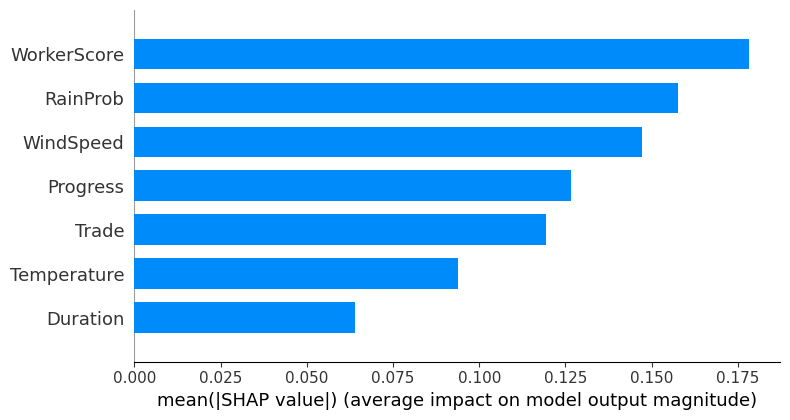

INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpe8y66728\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpe8y66728\assets


MAE Train: 0.9665191335325054, MAE Validation: 1.1976519071310758


In [28]:
def build_model(hp, input_shape):
    model = Sequential()
    model.add(Dense(units=hp.Int('units1', min_value=32, max_value=512, step=32),
                    input_dim=input_shape,
                    activation='relu'))
    model.add(Dense(units=hp.Int('units2', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

def train_model(df, target, background_data):
    X = df.drop(columns=[target])
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    input_shape = X_train.shape[1]

    # Check feature variance
    print("Feature Variance:\n", X_train.var())

    # Hyperparameter tuning
    tuner = kt.RandomSearch(
        lambda hp: build_model(hp, input_shape=input_shape),
        objective='val_loss',
        max_trials=5,
        executions_per_trial=3,
        directory='my_dir',
        project_name='MLP_tuning'
    )

    tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=0)

    # Get the best model
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.hypermodel.build(best_hps)
    best_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=20, verbose=0)

    y_val_pred = best_model.predict(X_test)
    y_train_pred = best_model.predict(X_train)

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_val = mean_absolute_error(y_test, y_val_pred)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)

    print(f"MAE Train: {mae_train}, MAE Validation: {mae_val}")
    print(f"RMSE: {rmse_train}, R2: {r2_train}")

    # Use KernelExplainer for the MLP model
    explainer = shap.KernelExplainer(best_model.predict, background_data)
    shap_values = explainer.shap_values(X_test, nsamples=100)

    # Convert to NumPy array if it's not already
    shap_values = np.array(shap_values)

    # Print shape to ensure it's correct
    print("SHAP Values Shape:", shap_values.shape)

    # Create DataFrame for plotting
    X_test_df = pd.DataFrame(X_test, columns=X.columns)

    print("X_test DataFrame shape:", X_test_df.shape)

    # Summary plot
    shap.summary_plot(
        shap_values[0],  # Use shap_values[0] for the first output
        X_test_df, 
        plot_type="bar", 
        feature_names=X.columns,
    )

    # Save the best model using joblib
    joblib.dump(best_model, './model/30_2019_v6_MLP.pkl')
    
    return best_model, explainer, mae_train, mae_val

processed_df = preprocess_project(df2)
train_df = processed_df.drop(columns=['ID', 'Outline_Number','Name','StartDate','EndDate', 'Predecessors', 'Successors', 'ActualStartDate','ActualEndDate'])
background_data = train_df.drop(columns=['Delay']).sample(n=100, random_state=42)
background_data.to_csv("./data/New_Dummy/background_data.csv")
# print(train_df.columns)

model, explainer, mae_train, mae_val = train_model(train_df, 'Delay', background_data)

print(f"MAE Train: {mae_train}, MAE Validation: {mae_val}")

## CNN

Feature Variance:
 [[1287.4752851 ]
 [ 108.92865134]
 [ 872.53061364]
 [ 687.89081727]
 [  56.23808896]
 [ 879.97103592]
 [ 290.71393745]]
Reloading Tuner from my_dir\CNN_tuning\tuner0.json
38/38 [==============================] - 0s 2ms/step
MAE Train: 0.8042749350170045, MAE Validation: 1.2439156550665695
RMSE: 1.1818562545376126, R2: 0.3493458486250759
4/4 [==============================] - 0s 2ms/step


  0%|          | 0/300 [00:00<?, ?it/s]

313/313 [==============================] - 0s 2ms/step


  0%|          | 1/300 [00:00<03:14,  1.54it/s]

313/313 [==============================] - 0s 2ms/step


  1%|          | 2/300 [00:01<03:14,  1.53it/s]

313/313 [==============================] - 1s 2ms/step


  1%|          | 3/300 [00:01<03:14,  1.53it/s]

313/313 [==============================] - 0s 2ms/step


  1%|▏         | 4/300 [00:02<03:12,  1.54it/s]

313/313 [==============================] - 0s 2ms/step


  2%|▏         | 5/300 [00:03<03:11,  1.54it/s]

313/313 [==============================] - 1s 2ms/step


  2%|▏         | 6/300 [00:03<03:11,  1.53it/s]

313/313 [==============================] - 1s 2ms/step


  2%|▏         | 7/300 [00:04<03:13,  1.51it/s]

313/313 [==============================] - 1s 2ms/step


  3%|▎         | 8/300 [00:05<03:12,  1.52it/s]

313/313 [==============================] - 1s 2ms/step


  3%|▎         | 9/300 [00:05<03:12,  1.51it/s]

313/313 [==============================] - 1s 2ms/step


  3%|▎         | 10/300 [00:06<03:11,  1.52it/s]

313/313 [==============================] - 1s 2ms/step


  4%|▎         | 11/300 [00:07<03:10,  1.52it/s]

313/313 [==============================] - 1s 2ms/step


  4%|▍         | 12/300 [00:07<03:09,  1.52it/s]

313/313 [==============================] - 1s 2ms/step


  4%|▍         | 13/300 [00:08<03:09,  1.52it/s]

313/313 [==============================] - 1s 2ms/step


  5%|▍         | 14/300 [00:09<03:08,  1.52it/s]

313/313 [==============================] - 1s 2ms/step


  5%|▌         | 15/300 [00:09<03:08,  1.51it/s]

313/313 [==============================] - 1s 2ms/step


  5%|▌         | 16/300 [00:10<03:08,  1.51it/s]

313/313 [==============================] - 1s 2ms/step


  6%|▌         | 17/300 [00:11<03:07,  1.51it/s]

313/313 [==============================] - 1s 2ms/step


  6%|▌         | 18/300 [00:11<03:06,  1.51it/s]

313/313 [==============================] - 1s 2ms/step


  6%|▋         | 19/300 [00:12<03:06,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


  7%|▋         | 20/300 [00:13<03:07,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


  7%|▋         | 21/300 [00:13<03:08,  1.48it/s]

313/313 [==============================] - 1s 2ms/step


  7%|▋         | 22/300 [00:14<03:06,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


  8%|▊         | 23/300 [00:15<03:05,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


  8%|▊         | 24/300 [00:15<03:05,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


  8%|▊         | 25/300 [00:16<03:03,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


  9%|▊         | 26/300 [00:17<03:04,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


  9%|▉         | 27/300 [00:17<03:03,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


  9%|▉         | 28/300 [00:18<03:04,  1.48it/s]

313/313 [==============================] - 1s 2ms/step


 10%|▉         | 29/300 [00:19<03:02,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 10%|█         | 30/300 [00:19<03:00,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 10%|█         | 31/300 [00:20<02:59,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 11%|█         | 32/300 [00:21<02:59,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 11%|█         | 33/300 [00:21<02:59,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 11%|█▏        | 34/300 [00:22<02:58,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 12%|█▏        | 35/300 [00:23<02:57,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 12%|█▏        | 36/300 [00:23<02:55,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 12%|█▏        | 37/300 [00:24<02:54,  1.51it/s]

313/313 [==============================] - 1s 2ms/step


 13%|█▎        | 38/300 [00:25<02:53,  1.51it/s]

313/313 [==============================] - 1s 2ms/step


 13%|█▎        | 39/300 [00:25<02:53,  1.51it/s]

313/313 [==============================] - 1s 2ms/step


 13%|█▎        | 40/300 [00:26<02:53,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 14%|█▎        | 41/300 [00:27<02:53,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 14%|█▍        | 42/300 [00:27<02:52,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 14%|█▍        | 43/300 [00:28<02:51,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 15%|█▍        | 44/300 [00:29<02:50,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 15%|█▌        | 45/300 [00:29<02:50,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 15%|█▌        | 46/300 [00:30<02:49,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 16%|█▌        | 47/300 [00:31<02:49,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 16%|█▌        | 48/300 [00:31<02:48,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 16%|█▋        | 49/300 [00:32<02:48,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 17%|█▋        | 50/300 [00:33<02:48,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 17%|█▋        | 51/300 [00:33<02:46,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 17%|█▋        | 52/300 [00:34<02:46,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 18%|█▊        | 53/300 [00:35<02:45,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 18%|█▊        | 54/300 [00:35<02:44,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 18%|█▊        | 55/300 [00:36<02:43,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 19%|█▊        | 56/300 [00:37<02:43,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 19%|█▉        | 57/300 [00:37<02:43,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 19%|█▉        | 58/300 [00:38<02:42,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 20%|█▉        | 59/300 [00:39<02:40,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 20%|██        | 60/300 [00:39<02:40,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 20%|██        | 61/300 [00:40<02:40,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 21%|██        | 62/300 [00:41<02:39,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 21%|██        | 63/300 [00:41<02:38,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 21%|██▏       | 64/300 [00:42<02:37,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 22%|██▏       | 65/300 [00:43<02:37,  1.49it/s]

313/313 [==============================] - 0s 2ms/step


 22%|██▏       | 66/300 [00:43<02:35,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 22%|██▏       | 67/300 [00:44<02:34,  1.51it/s]

313/313 [==============================] - 1s 2ms/step


 23%|██▎       | 68/300 [00:45<02:33,  1.51it/s]

313/313 [==============================] - 1s 2ms/step


 23%|██▎       | 69/300 [00:45<02:33,  1.51it/s]

313/313 [==============================] - 0s 2ms/step


 23%|██▎       | 70/300 [00:46<02:31,  1.52it/s]

313/313 [==============================] - 0s 2ms/step


 24%|██▎       | 71/300 [00:47<02:30,  1.52it/s]

313/313 [==============================] - 0s 2ms/step


 24%|██▍       | 72/300 [00:47<02:29,  1.53it/s]

313/313 [==============================] - 0s 2ms/step


 24%|██▍       | 73/300 [00:48<02:29,  1.51it/s]

313/313 [==============================] - 0s 2ms/step


 25%|██▍       | 74/300 [00:49<02:28,  1.52it/s]

313/313 [==============================] - 1s 2ms/step


 25%|██▌       | 75/300 [00:49<02:27,  1.52it/s]

313/313 [==============================] - 0s 2ms/step


 25%|██▌       | 76/300 [00:50<02:26,  1.53it/s]

313/313 [==============================] - 0s 2ms/step


 26%|██▌       | 77/300 [00:51<02:25,  1.53it/s]

313/313 [==============================] - 0s 2ms/step


 26%|██▌       | 78/300 [00:51<02:25,  1.53it/s]

313/313 [==============================] - 0s 2ms/step


 26%|██▋       | 79/300 [00:52<02:24,  1.53it/s]

313/313 [==============================] - 1s 2ms/step


 27%|██▋       | 80/300 [00:53<02:23,  1.53it/s]

313/313 [==============================] - 1s 2ms/step


 27%|██▋       | 81/300 [00:53<02:24,  1.51it/s]

313/313 [==============================] - 0s 2ms/step


 27%|██▋       | 82/300 [00:54<02:23,  1.52it/s]

313/313 [==============================] - 0s 2ms/step


 28%|██▊       | 83/300 [00:55<02:21,  1.53it/s]

313/313 [==============================] - 1s 2ms/step


 28%|██▊       | 84/300 [00:55<02:22,  1.52it/s]

313/313 [==============================] - 1s 2ms/step


 28%|██▊       | 85/300 [00:56<02:21,  1.52it/s]

313/313 [==============================] - 0s 2ms/step


 29%|██▊       | 86/300 [00:57<02:20,  1.52it/s]

313/313 [==============================] - 0s 2ms/step


 29%|██▉       | 87/300 [00:57<02:18,  1.54it/s]

313/313 [==============================] - 1s 2ms/step


 29%|██▉       | 88/300 [00:58<02:19,  1.52it/s]

313/313 [==============================] - 0s 2ms/step


 30%|██▉       | 89/300 [00:59<02:17,  1.53it/s]

313/313 [==============================] - 0s 2ms/step


 30%|███       | 90/300 [00:59<02:16,  1.54it/s]

313/313 [==============================] - 0s 2ms/step


 30%|███       | 91/300 [01:00<02:16,  1.53it/s]

313/313 [==============================] - 1s 2ms/step


 31%|███       | 92/300 [01:01<02:15,  1.53it/s]

313/313 [==============================] - 1s 2ms/step


 31%|███       | 93/300 [01:01<02:15,  1.52it/s]

313/313 [==============================] - 1s 2ms/step


 31%|███▏      | 94/300 [01:02<02:15,  1.52it/s]

313/313 [==============================] - 1s 2ms/step


 32%|███▏      | 95/300 [01:03<02:15,  1.52it/s]

313/313 [==============================] - 1s 2ms/step


 32%|███▏      | 96/300 [01:03<02:16,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 32%|███▏      | 97/300 [01:04<02:16,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 33%|███▎      | 98/300 [01:05<02:15,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 33%|███▎      | 99/300 [01:05<02:14,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 33%|███▎      | 100/300 [01:06<02:13,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 34%|███▎      | 101/300 [01:07<02:12,  1.51it/s]

313/313 [==============================] - 1s 2ms/step


 34%|███▍      | 102/300 [01:07<02:10,  1.51it/s]

313/313 [==============================] - 1s 2ms/step


 34%|███▍      | 103/300 [01:08<02:10,  1.51it/s]

313/313 [==============================] - 1s 2ms/step


 35%|███▍      | 104/300 [01:09<02:10,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 35%|███▌      | 105/300 [01:09<02:09,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 35%|███▌      | 106/300 [01:10<02:09,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 36%|███▌      | 107/300 [01:11<02:08,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 36%|███▌      | 108/300 [01:11<02:07,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 36%|███▋      | 109/300 [01:12<02:07,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 37%|███▋      | 110/300 [01:13<02:07,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 37%|███▋      | 111/300 [01:13<02:06,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 37%|███▋      | 112/300 [01:14<02:06,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 38%|███▊      | 113/300 [01:15<02:05,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 38%|███▊      | 114/300 [01:15<02:05,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 38%|███▊      | 115/300 [01:16<02:04,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 39%|███▊      | 116/300 [01:17<02:03,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 39%|███▉      | 117/300 [01:17<02:02,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 39%|███▉      | 118/300 [01:18<02:01,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 40%|███▉      | 119/300 [01:19<02:02,  1.48it/s]

313/313 [==============================] - 1s 2ms/step


 40%|████      | 120/300 [01:19<02:01,  1.48it/s]

313/313 [==============================] - 1s 2ms/step


 40%|████      | 121/300 [01:20<02:01,  1.48it/s]

313/313 [==============================] - 1s 2ms/step


 41%|████      | 122/300 [01:21<02:19,  1.27it/s]

313/313 [==============================] - 0s 2ms/step


 41%|████      | 123/300 [01:22<02:11,  1.34it/s]

313/313 [==============================] - 0s 2ms/step


 41%|████▏     | 124/300 [01:22<02:05,  1.40it/s]

313/313 [==============================] - 0s 2ms/step


 42%|████▏     | 125/300 [01:23<02:01,  1.44it/s]

313/313 [==============================] - 1s 2ms/step


 42%|████▏     | 126/300 [01:24<01:59,  1.46it/s]

313/313 [==============================] - 1s 2ms/step


 42%|████▏     | 127/300 [01:24<01:56,  1.48it/s]

313/313 [==============================] - 1s 2ms/step


 43%|████▎     | 128/300 [01:25<01:55,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 43%|████▎     | 129/300 [01:26<01:54,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 43%|████▎     | 130/300 [01:26<01:53,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 44%|████▎     | 131/300 [01:27<01:52,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 44%|████▍     | 132/300 [01:28<01:51,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 44%|████▍     | 133/300 [01:28<01:50,  1.51it/s]

313/313 [==============================] - 1s 2ms/step


 45%|████▍     | 134/300 [01:29<01:50,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 45%|████▌     | 135/300 [01:30<01:49,  1.51it/s]

313/313 [==============================] - 0s 2ms/step


 45%|████▌     | 136/300 [01:30<01:47,  1.52it/s]

313/313 [==============================] - 0s 2ms/step


 46%|████▌     | 137/300 [01:31<01:46,  1.53it/s]

313/313 [==============================] - 0s 2ms/step


 46%|████▌     | 138/300 [01:31<01:45,  1.54it/s]

313/313 [==============================] - 0s 2ms/step


 46%|████▋     | 139/300 [01:32<01:44,  1.54it/s]

313/313 [==============================] - 1s 2ms/step


 47%|████▋     | 140/300 [01:33<01:44,  1.53it/s]

313/313 [==============================] - 1s 2ms/step


 47%|████▋     | 141/300 [01:33<01:44,  1.53it/s]

313/313 [==============================] - 1s 2ms/step


 47%|████▋     | 142/300 [01:34<01:44,  1.51it/s]

313/313 [==============================] - 0s 2ms/step


 48%|████▊     | 143/300 [01:35<01:43,  1.52it/s]

313/313 [==============================] - 0s 2ms/step


 48%|████▊     | 144/300 [01:35<01:42,  1.53it/s]

313/313 [==============================] - 0s 2ms/step


 48%|████▊     | 145/300 [01:36<01:41,  1.53it/s]

313/313 [==============================] - 0s 2ms/step


 49%|████▊     | 146/300 [01:37<01:40,  1.53it/s]

313/313 [==============================] - 1s 2ms/step


 49%|████▉     | 147/300 [01:37<01:40,  1.53it/s]

313/313 [==============================] - 1s 2ms/step


 49%|████▉     | 148/300 [01:38<01:39,  1.52it/s]

313/313 [==============================] - 1s 2ms/step


 50%|████▉     | 149/300 [01:39<01:40,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 50%|█████     | 150/300 [01:39<01:40,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 50%|█████     | 151/300 [01:40<01:39,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 51%|█████     | 152/300 [01:41<01:38,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 51%|█████     | 153/300 [01:41<01:38,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 51%|█████▏    | 154/300 [01:42<01:37,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 52%|█████▏    | 155/300 [01:43<01:36,  1.50it/s]

313/313 [==============================] - 1s 2ms/step


 52%|█████▏    | 156/300 [01:43<01:36,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 52%|█████▏    | 157/300 [01:44<01:35,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 53%|█████▎    | 158/300 [01:45<01:35,  1.49it/s]

313/313 [==============================] - 1s 2ms/step


 53%|█████▎    | 159/300 [01:45<01:34,  1.48it/s]

313/313 [==============================] - 1s 2ms/step


 53%|█████▎    | 160/300 [01:46<01:34,  1.48it/s]

313/313 [==============================] - 1s 2ms/step


 54%|█████▎    | 161/300 [01:47<01:34,  1.48it/s]

313/313 [==============================] - 1s 2ms/step


 54%|█████▍    | 162/300 [01:47<01:33,  1.48it/s]

313/313 [==============================] - 1s 2ms/step


 54%|█████▍    | 163/300 [01:48<01:32,  1.48it/s]

313/313 [==============================] - 1s 2ms/step


 55%|█████▍    | 164/300 [01:49<01:32,  1.47it/s]

313/313 [==============================] - 1s 2ms/step


 55%|█████▌    | 165/300 [01:50<01:32,  1.46it/s]

313/313 [==============================] - 1s 2ms/step


 55%|█████▌    | 166/300 [01:50<01:31,  1.47it/s]

313/313 [==============================] - 1s 2ms/step


 56%|█████▌    | 167/300 [01:51<01:30,  1.47it/s]

313/313 [==============================] - 1s 2ms/step


 56%|█████▌    | 168/300 [01:52<01:30,  1.47it/s]

313/313 [==============================] - 1s 2ms/step


 56%|█████▋    | 169/300 [01:52<01:29,  1.46it/s]

313/313 [==============================] - 1s 2ms/step


 57%|█████▋    | 170/300 [01:53<01:29,  1.46it/s]

313/313 [==============================] - 1s 2ms/step


 57%|█████▋    | 171/300 [01:54<01:28,  1.45it/s]

313/313 [==============================] - 1s 2ms/step


 57%|█████▋    | 172/300 [01:54<01:28,  1.44it/s]

313/313 [==============================] - 1s 2ms/step


 58%|█████▊    | 173/300 [01:55<01:27,  1.45it/s]

313/313 [==============================] - 1s 2ms/step


 58%|█████▊    | 174/300 [01:56<01:26,  1.45it/s]

313/313 [==============================] - 1s 2ms/step


 58%|█████▊    | 175/300 [01:56<01:25,  1.45it/s]

313/313 [==============================] - 1s 2ms/step


 59%|█████▊    | 176/300 [01:57<01:25,  1.46it/s]

313/313 [==============================] - 1s 2ms/step


 59%|█████▉    | 177/300 [01:58<01:23,  1.47it/s]

313/313 [==============================] - 1s 2ms/step


 59%|█████▉    | 178/300 [01:58<01:23,  1.46it/s]

313/313 [==============================] - 1s 2ms/step


 60%|█████▉    | 179/300 [01:59<01:22,  1.46it/s]

313/313 [==============================] - 1s 2ms/step


 60%|██████    | 180/300 [02:00<01:22,  1.45it/s]

313/313 [==============================] - 1s 2ms/step


 60%|██████    | 181/300 [02:01<01:21,  1.46it/s]

313/313 [==============================] - 1s 2ms/step


 61%|██████    | 182/300 [02:01<01:21,  1.45it/s]

313/313 [==============================] - 1s 2ms/step


 61%|██████    | 183/300 [02:02<01:20,  1.45it/s]

313/313 [==============================] - 1s 2ms/step


 61%|██████▏   | 184/300 [02:03<01:20,  1.45it/s]

313/313 [==============================] - 1s 2ms/step


 62%|██████▏   | 185/300 [02:03<01:19,  1.44it/s]

313/313 [==============================] - 1s 2ms/step


 62%|██████▏   | 186/300 [02:04<01:18,  1.45it/s]

313/313 [==============================] - 1s 2ms/step


 62%|██████▏   | 187/300 [02:05<01:18,  1.44it/s]

313/313 [==============================] - 1s 2ms/step


 63%|██████▎   | 188/300 [02:05<01:18,  1.44it/s]

313/313 [==============================] - 1s 2ms/step


 63%|██████▎   | 189/300 [02:06<01:17,  1.44it/s]

313/313 [==============================] - 1s 2ms/step


 63%|██████▎   | 190/300 [02:07<01:16,  1.44it/s]

313/313 [==============================] - 1s 2ms/step


 64%|██████▎   | 191/300 [02:07<01:15,  1.44it/s]

313/313 [==============================] - 1s 2ms/step


 64%|██████▍   | 192/300 [02:08<01:15,  1.44it/s]

313/313 [==============================] - 1s 2ms/step


 64%|██████▍   | 193/300 [02:09<01:14,  1.44it/s]

313/313 [==============================] - 1s 2ms/step


 65%|██████▍   | 194/300 [02:10<01:13,  1.44it/s]

313/313 [==============================] - 1s 2ms/step


 65%|██████▌   | 195/300 [02:10<01:13,  1.43it/s]

313/313 [==============================] - 1s 2ms/step


 65%|██████▌   | 196/300 [02:11<01:12,  1.44it/s]

313/313 [==============================] - 1s 2ms/step


 66%|██████▌   | 197/300 [02:12<01:11,  1.43it/s]

313/313 [==============================] - 1s 2ms/step


 66%|██████▌   | 198/300 [02:12<01:11,  1.43it/s]

313/313 [==============================] - 1s 2ms/step


 66%|██████▋   | 199/300 [02:13<01:10,  1.44it/s]

313/313 [==============================] - 1s 2ms/step


 67%|██████▋   | 200/300 [02:14<01:09,  1.45it/s]

313/313 [==============================] - 1s 2ms/step


 67%|██████▋   | 201/300 [02:14<01:08,  1.45it/s]

313/313 [==============================] - 1s 2ms/step


 67%|██████▋   | 202/300 [02:15<01:07,  1.44it/s]

313/313 [==============================] - 1s 2ms/step


 68%|██████▊   | 203/300 [02:16<01:06,  1.45it/s]

313/313 [==============================] - 1s 2ms/step


 68%|██████▊   | 204/300 [02:16<01:06,  1.45it/s]

313/313 [==============================] - 1s 2ms/step


 68%|██████▊   | 205/300 [02:17<01:05,  1.45it/s]

313/313 [==============================] - 1s 2ms/step


 69%|██████▊   | 206/300 [02:18<01:05,  1.43it/s]

313/313 [==============================] - 1s 2ms/step


 69%|██████▉   | 207/300 [02:19<01:05,  1.42it/s]

313/313 [==============================] - 1s 2ms/step


 69%|██████▉   | 208/300 [02:19<01:04,  1.42it/s]

313/313 [==============================] - 1s 2ms/step


 70%|██████▉   | 209/300 [02:20<01:04,  1.41it/s]

313/313 [==============================] - 1s 2ms/step


 70%|███████   | 210/300 [02:21<01:04,  1.40it/s]

313/313 [==============================] - 1s 2ms/step


 70%|███████   | 211/300 [02:21<01:04,  1.39it/s]

313/313 [==============================] - 1s 2ms/step


 71%|███████   | 212/300 [02:22<01:03,  1.40it/s]

313/313 [==============================] - 1s 2ms/step


 71%|███████   | 213/300 [02:23<01:02,  1.39it/s]

313/313 [==============================] - 1s 2ms/step


 71%|███████▏  | 214/300 [02:24<01:02,  1.38it/s]

313/313 [==============================] - 1s 2ms/step


 72%|███████▏  | 215/300 [02:24<01:01,  1.38it/s]

313/313 [==============================] - 1s 2ms/step


 72%|███████▏  | 216/300 [02:25<01:01,  1.37it/s]

313/313 [==============================] - 1s 2ms/step


 72%|███████▏  | 217/300 [02:26<01:01,  1.36it/s]

313/313 [==============================] - 1s 2ms/step


 73%|███████▎  | 218/300 [02:27<00:59,  1.37it/s]

313/313 [==============================] - 1s 2ms/step


 73%|███████▎  | 219/300 [02:27<00:58,  1.38it/s]

313/313 [==============================] - 1s 2ms/step


 73%|███████▎  | 220/300 [02:28<00:57,  1.38it/s]

313/313 [==============================] - 1s 2ms/step


 74%|███████▎  | 221/300 [02:29<00:57,  1.38it/s]

313/313 [==============================] - 1s 2ms/step


 74%|███████▍  | 222/300 [02:29<00:56,  1.38it/s]

313/313 [==============================] - 1s 2ms/step


 74%|███████▍  | 223/300 [02:30<00:56,  1.37it/s]

313/313 [==============================] - 1s 2ms/step


 75%|███████▍  | 224/300 [02:31<00:55,  1.37it/s]

313/313 [==============================] - 1s 2ms/step


 75%|███████▌  | 225/300 [02:32<00:55,  1.36it/s]

313/313 [==============================] - 1s 2ms/step


 75%|███████▌  | 226/300 [02:32<00:54,  1.36it/s]

313/313 [==============================] - 1s 2ms/step


 76%|███████▌  | 227/300 [02:33<00:53,  1.36it/s]

313/313 [==============================] - 1s 2ms/step


 76%|███████▌  | 228/300 [02:34<00:53,  1.36it/s]

313/313 [==============================] - 1s 2ms/step


 76%|███████▋  | 229/300 [02:35<00:52,  1.36it/s]

313/313 [==============================] - 1s 2ms/step


 77%|███████▋  | 230/300 [02:35<00:51,  1.36it/s]

313/313 [==============================] - 1s 2ms/step


 77%|███████▋  | 231/300 [02:36<00:51,  1.35it/s]

313/313 [==============================] - 1s 2ms/step


 77%|███████▋  | 232/300 [02:37<00:50,  1.35it/s]

313/313 [==============================] - 1s 2ms/step


 78%|███████▊  | 233/300 [02:38<00:50,  1.33it/s]

313/313 [==============================] - 1s 2ms/step


 78%|███████▊  | 234/300 [02:38<00:49,  1.34it/s]

313/313 [==============================] - 1s 2ms/step


 78%|███████▊  | 235/300 [02:39<00:48,  1.35it/s]

313/313 [==============================] - 1s 2ms/step


 79%|███████▊  | 236/300 [02:40<00:47,  1.35it/s]

313/313 [==============================] - 1s 2ms/step


 79%|███████▉  | 237/300 [02:41<00:46,  1.35it/s]

313/313 [==============================] - 1s 2ms/step


 79%|███████▉  | 238/300 [02:41<00:45,  1.36it/s]

313/313 [==============================] - 1s 2ms/step


 80%|███████▉  | 239/300 [02:42<00:43,  1.39it/s]

313/313 [==============================] - 1s 2ms/step


 80%|████████  | 240/300 [02:43<00:43,  1.39it/s]

313/313 [==============================] - 1s 2ms/step


 80%|████████  | 241/300 [02:43<00:42,  1.39it/s]

313/313 [==============================] - 1s 2ms/step


 81%|████████  | 242/300 [02:44<00:42,  1.36it/s]

313/313 [==============================] - 1s 2ms/step


 81%|████████  | 243/300 [02:45<00:41,  1.36it/s]

313/313 [==============================] - 1s 2ms/step


 81%|████████▏ | 244/300 [02:46<00:41,  1.36it/s]

313/313 [==============================] - 1s 2ms/step


 82%|████████▏ | 245/300 [02:46<00:40,  1.35it/s]

313/313 [==============================] - 1s 2ms/step


 82%|████████▏ | 246/300 [02:47<00:40,  1.35it/s]

313/313 [==============================] - 1s 2ms/step


 82%|████████▏ | 247/300 [02:48<00:39,  1.35it/s]

313/313 [==============================] - 1s 2ms/step


 83%|████████▎ | 248/300 [02:49<00:38,  1.34it/s]

313/313 [==============================] - 1s 2ms/step


 83%|████████▎ | 249/300 [02:49<00:37,  1.34it/s]

313/313 [==============================] - 1s 2ms/step


 83%|████████▎ | 250/300 [02:50<00:37,  1.33it/s]

313/313 [==============================] - 1s 2ms/step


 84%|████████▎ | 251/300 [02:51<00:36,  1.33it/s]

313/313 [==============================] - 1s 2ms/step


 84%|████████▍ | 252/300 [02:52<00:36,  1.33it/s]

313/313 [==============================] - 1s 2ms/step


 84%|████████▍ | 253/300 [02:52<00:35,  1.32it/s]

313/313 [==============================] - 1s 2ms/step


 85%|████████▍ | 254/300 [02:53<00:34,  1.34it/s]

313/313 [==============================] - 1s 2ms/step


 85%|████████▌ | 255/300 [02:54<00:33,  1.35it/s]

313/313 [==============================] - 1s 2ms/step


 85%|████████▌ | 256/300 [02:55<00:32,  1.33it/s]

313/313 [==============================] - 1s 2ms/step


 86%|████████▌ | 257/300 [02:55<00:32,  1.33it/s]

313/313 [==============================] - 1s 2ms/step


 86%|████████▌ | 258/300 [02:56<00:32,  1.31it/s]

313/313 [==============================] - 1s 2ms/step


 86%|████████▋ | 259/300 [02:57<00:31,  1.32it/s]

313/313 [==============================] - 1s 2ms/step


 87%|████████▋ | 260/300 [02:58<00:30,  1.32it/s]

313/313 [==============================] - 1s 2ms/step


 87%|████████▋ | 261/300 [02:58<00:29,  1.34it/s]

313/313 [==============================] - 1s 2ms/step


 87%|████████▋ | 262/300 [02:59<00:28,  1.33it/s]

313/313 [==============================] - 1s 2ms/step


 88%|████████▊ | 263/300 [03:00<00:27,  1.33it/s]

313/313 [==============================] - 1s 2ms/step


 88%|████████▊ | 264/300 [03:01<00:27,  1.33it/s]

313/313 [==============================] - 1s 2ms/step


 88%|████████▊ | 265/300 [03:01<00:26,  1.33it/s]

313/313 [==============================] - 1s 2ms/step


 89%|████████▊ | 266/300 [03:02<00:25,  1.33it/s]

313/313 [==============================] - 1s 2ms/step


 89%|████████▉ | 267/300 [03:03<00:24,  1.34it/s]

313/313 [==============================] - 1s 2ms/step


 89%|████████▉ | 268/300 [03:04<00:24,  1.33it/s]

313/313 [==============================] - 1s 2ms/step


 90%|████████▉ | 269/300 [03:04<00:23,  1.33it/s]

313/313 [==============================] - 1s 2ms/step


 90%|█████████ | 270/300 [03:05<00:22,  1.35it/s]

313/313 [==============================] - 1s 2ms/step


 90%|█████████ | 271/300 [03:06<00:21,  1.35it/s]

313/313 [==============================] - 1s 2ms/step


 91%|█████████ | 272/300 [03:07<00:21,  1.33it/s]

313/313 [==============================] - 1s 2ms/step


 91%|█████████ | 273/300 [03:07<00:20,  1.34it/s]

313/313 [==============================] - 1s 2ms/step


 91%|█████████▏| 274/300 [03:08<00:19,  1.33it/s]

313/313 [==============================] - 1s 2ms/step


 92%|█████████▏| 275/300 [03:09<00:19,  1.31it/s]

313/313 [==============================] - 1s 2ms/step


 92%|█████████▏| 276/300 [03:10<00:18,  1.30it/s]

313/313 [==============================] - 1s 2ms/step


 92%|█████████▏| 277/300 [03:11<00:17,  1.32it/s]

313/313 [==============================] - 1s 2ms/step


 93%|█████████▎| 278/300 [03:11<00:16,  1.33it/s]

313/313 [==============================] - 1s 2ms/step


 93%|█████████▎| 279/300 [03:12<00:15,  1.34it/s]

313/313 [==============================] - 1s 2ms/step


 93%|█████████▎| 280/300 [03:13<00:15,  1.33it/s]

313/313 [==============================] - 1s 2ms/step


 94%|█████████▎| 281/300 [03:14<00:14,  1.32it/s]

313/313 [==============================] - 1s 2ms/step


 94%|█████████▍| 282/300 [03:14<00:13,  1.34it/s]

313/313 [==============================] - 1s 2ms/step


 94%|█████████▍| 283/300 [03:15<00:12,  1.31it/s]

313/313 [==============================] - 1s 2ms/step


 95%|█████████▍| 284/300 [03:16<00:12,  1.32it/s]

313/313 [==============================] - 1s 2ms/step


 95%|█████████▌| 285/300 [03:17<00:11,  1.31it/s]

313/313 [==============================] - 1s 2ms/step


 95%|█████████▌| 286/300 [03:17<00:10,  1.31it/s]

313/313 [==============================] - 1s 2ms/step


 96%|█████████▌| 287/300 [03:18<00:09,  1.32it/s]

313/313 [==============================] - 1s 2ms/step


 96%|█████████▌| 288/300 [03:19<00:09,  1.31it/s]

313/313 [==============================] - 1s 2ms/step


 96%|█████████▋| 289/300 [03:20<00:08,  1.32it/s]

313/313 [==============================] - 1s 2ms/step


 97%|█████████▋| 290/300 [03:20<00:07,  1.32it/s]

313/313 [==============================] - 1s 2ms/step


 97%|█████████▋| 291/300 [03:21<00:06,  1.33it/s]

313/313 [==============================] - 1s 2ms/step


 97%|█████████▋| 292/300 [03:22<00:05,  1.34it/s]

313/313 [==============================] - 1s 2ms/step


 98%|█████████▊| 293/300 [03:23<00:05,  1.33it/s]

313/313 [==============================] - 1s 2ms/step


 98%|█████████▊| 294/300 [03:23<00:04,  1.33it/s]

313/313 [==============================] - 1s 2ms/step


 98%|█████████▊| 295/300 [03:24<00:03,  1.32it/s]

313/313 [==============================] - 1s 2ms/step


 99%|█████████▊| 296/300 [03:25<00:03,  1.32it/s]

313/313 [==============================] - 1s 2ms/step


 99%|█████████▉| 297/300 [03:26<00:02,  1.34it/s]

313/313 [==============================] - 1s 2ms/step


 99%|█████████▉| 298/300 [03:26<00:01,  1.32it/s]

313/313 [==============================] - 1s 2ms/step


100%|█████████▉| 299/300 [03:27<00:00,  1.31it/s]

313/313 [==============================] - 1s 2ms/step


100%|██████████| 300/300 [03:28<00:00,  1.44it/s]

SHAP Values Shape: (1, 300, 7)
X_test DataFrame Shape: (300, 7)


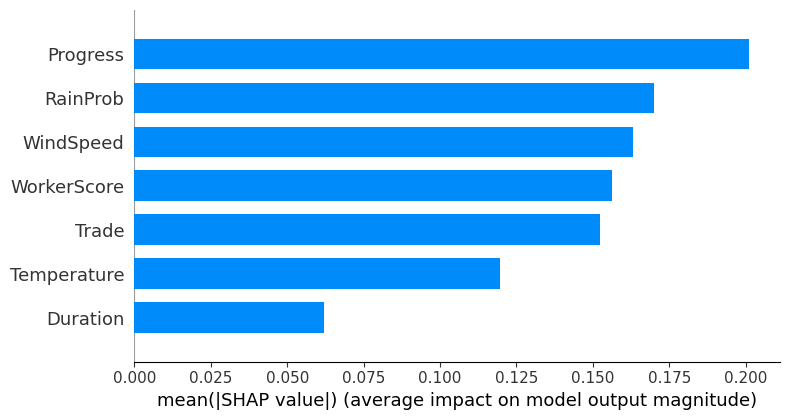

INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpglwp1y7x\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpglwp1y7x\assets


MAE Train: 0.8042749350170045, MAE Validation: 1.2439156550665695


In [29]:
def build_model(hp, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Int('kernel_size', min_value=2, max_value=5, step=1),
                     activation='relu',
                     input_shape=(input_shape, 1)))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units1', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

def train_model(df, target, background_data):
    X = df.drop(columns=[target])
    y = df[target]
    
    # Reshape the input for Conv1D
    X = np.expand_dims(X.values, axis=2)
    background_data = np.expand_dims(background_data.values, axis=2)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    input_shape = X_train.shape[1]

    # Check feature variance
    print("Feature Variance:\n", X_train.var(axis=0))

    # Hyperparameter tuning
    tuner = kt.RandomSearch(
        lambda hp: build_model(hp, input_shape=input_shape),
        objective='val_loss',
        max_trials=5,
        executions_per_trial=3,
        directory='my_dir',
        project_name='CNN_tuning'
    )

    tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)

    # Get the best model
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.hypermodel.build(best_hps)
    history = best_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=20, verbose=0)

    y_val_pred = best_model.predict(X_test)
    y_train_pred = best_model.predict(X_train)

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_val = mean_absolute_error(y_test, y_val_pred)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)

    print(f"MAE Train: {mae_train}, MAE Validation: {mae_val}")
    print(f"RMSE: {rmse_train}, R2: {r2_train}")

    # Use KernelExplainer for the CNN model
    def model_predict(data):
        return best_model.predict(np.expand_dims(data, axis=2))
    
    explainer = shap.KernelExplainer(model_predict, background_data.squeeze(axis=2))
    shap_values = explainer.shap_values(X_test.squeeze(axis=2), nsamples=100)

    # Convert SHAP values to a NumPy array
    shap_values = np.array(shap_values)
    
    # Print shapes to debug
    print("SHAP Values Shape:", shap_values.shape)
    
    # Create DataFrame for plotting
    X_test_df = pd.DataFrame(X_test.squeeze(axis=2), columns=df.drop(columns=[target]).columns)
    print("X_test DataFrame Shape:", X_test_df.shape)

    shap.summary_plot(
        shap_values[0],  # Using the first set of SHAP values if there are multiple outputs
        X_test_df, 
        plot_type="bar", 
        feature_names=df.drop(columns=[target]).columns,
    )

    # Save the best model using joblib
    joblib.dump(best_model, './model/30_2019_v6_CNN.pkl')
    
    return best_model, explainer, mae_train, mae_val

processed_df = preprocess_project(df2)
train_df = processed_df.drop(columns=['ID', 'Outline_Number','Name','StartDate','EndDate', 'Predecessors', 'Successors', 'ActualStartDate','ActualEndDate'])
background_data = train_df.drop(columns=['Delay']).sample(n=100, random_state=42)
background_data.to_csv("./data/New_Dummy/background_data.csv")
# print(train_df.columns)

model, explainer, mae_train, mae_val = train_model(train_df, 'Delay', background_data)

print(f"MAE Train: {mae_train}, MAE Validation: {mae_val}")

## LSTM

Feature Variance:
 [[1287.4752851 ]
 [ 108.92865134]
 [ 872.53061364]
 [ 687.89081727]
 [  56.23808896]
 [ 879.97103592]
 [ 290.71393745]]
Reloading Tuner from my_dir\LSTM_tuning\tuner0.json


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAE Train: 0.8379313251409763, MAE Validation: 1.1831752535824975
RMSE: 1.2545405714033726, R2: 0.26685428619384766
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  0%|          | 0/300 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  0%|          | 1/300 [00:01<05:38,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  1%|          | 2/300 [00:02<05:37,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  1%|          | 3/300 [00:03<05:34,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  1%|▏         | 4/300 [00:04<05:30,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  2%|▏         | 5/300 [00:05<05:32,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  2%|▏         | 6/300 [00:06<05:31,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  2%|▏         | 7/300 [00:07<05:29,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  3%|▎         | 8/300 [00:08<05:27,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  3%|▎         | 9/300 [00:10<05:23,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  3%|▎         | 10/300 [00:11<05:24,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  4%|▎         | 11/300 [00:12<05:26,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  4%|▍         | 12/300 [00:13<05:22,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  4%|▍         | 13/300 [00:14<05:20,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  5%|▍         | 14/300 [00:15<05:18,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  5%|▌         | 15/300 [00:16<05:16,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  5%|▌         | 16/300 [00:17<05:19,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  6%|▌         | 17/300 [00:19<05:17,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  6%|▌         | 18/300 [00:20<05:15,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  6%|▋         | 19/300 [00:21<05:13,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  7%|▋         | 20/300 [00:22<05:11,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  7%|▋         | 21/300 [00:23<05:10,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  7%|▋         | 22/300 [00:24<05:08,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  8%|▊         | 23/300 [00:25<05:07,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  8%|▊         | 24/300 [00:26<05:05,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  8%|▊         | 25/300 [00:27<05:06,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  9%|▊         | 26/300 [00:29<05:03,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  9%|▉         | 27/300 [00:30<05:03,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


  9%|▉         | 28/300 [00:31<05:00,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 10%|▉         | 29/300 [00:32<04:57,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 10%|█         | 30/300 [00:33<05:00,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 10%|█         | 31/300 [00:34<04:58,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 11%|█         | 32/300 [00:35<04:57,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 11%|█         | 33/300 [00:36<04:55,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 11%|█▏        | 34/300 [00:37<04:53,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 12%|█▏        | 35/300 [00:38<04:51,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 12%|█▏        | 36/300 [00:40<04:49,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 12%|█▏        | 37/300 [00:41<04:50,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 13%|█▎        | 38/300 [00:42<04:48,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 13%|█▎        | 39/300 [00:43<04:46,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 13%|█▎        | 40/300 [00:44<04:45,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 14%|█▎        | 41/300 [00:45<04:44,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 14%|█▍        | 42/300 [00:46<04:43,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 14%|█▍        | 43/300 [00:47<04:43,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 15%|█▍        | 44/300 [00:48<04:41,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 15%|█▌        | 45/300 [00:49<04:39,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 15%|█▌        | 46/300 [00:51<04:38,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 16%|█▌        | 47/300 [00:52<04:37,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 16%|█▌        | 48/300 [00:53<04:36,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 16%|█▋        | 49/300 [00:54<04:34,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 17%|█▋        | 50/300 [00:55<04:34,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 17%|█▋        | 51/300 [00:56<04:32,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 17%|█▋        | 52/300 [00:57<04:31,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 18%|█▊        | 53/300 [00:58<04:29,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 18%|█▊        | 54/300 [00:59<04:27,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 18%|█▊        | 55/300 [01:00<04:28,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 19%|█▊        | 56/300 [01:02<04:28,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 19%|█▉        | 57/300 [01:03<04:26,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 19%|█▉        | 58/300 [01:04<04:24,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 20%|█▉        | 59/300 [01:05<04:25,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 20%|██        | 60/300 [01:06<04:25,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 20%|██        | 61/300 [01:07<04:23,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 21%|██        | 62/300 [01:08<04:22,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 21%|██        | 63/300 [01:09<04:20,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 21%|██▏       | 64/300 [01:10<04:21,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 22%|██▏       | 65/300 [01:11<04:19,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 22%|██▏       | 66/300 [01:13<04:17,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 22%|██▏       | 67/300 [01:14<04:16,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 23%|██▎       | 68/300 [01:15<04:14,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 23%|██▎       | 69/300 [01:16<04:13,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 23%|██▎       | 70/300 [01:17<04:11,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 24%|██▎       | 71/300 [01:18<04:10,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 24%|██▍       | 72/300 [01:19<04:09,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 24%|██▍       | 73/300 [01:20<04:11,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 25%|██▍       | 74/300 [01:21<04:09,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 25%|██▌       | 75/300 [01:22<04:07,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 25%|██▌       | 76/300 [01:24<04:05,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 26%|██▌       | 77/300 [01:25<04:04,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 26%|██▌       | 78/300 [01:26<04:05,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 26%|██▋       | 79/300 [01:27<04:02,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 27%|██▋       | 80/300 [01:28<04:01,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 27%|██▋       | 81/300 [01:29<04:01,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 27%|██▋       | 82/300 [01:30<04:01,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 28%|██▊       | 83/300 [01:31<03:59,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 28%|██▊       | 84/300 [01:32<03:57,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 28%|██▊       | 85/300 [01:33<03:55,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 29%|██▊       | 86/300 [01:34<03:53,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 29%|██▉       | 87/300 [01:36<03:53,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 29%|██▉       | 88/300 [01:37<03:52,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 30%|██▉       | 89/300 [01:38<03:51,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 30%|███       | 90/300 [01:39<03:50,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 30%|███       | 91/300 [01:40<03:50,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 31%|███       | 92/300 [01:41<03:49,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 31%|███       | 93/300 [01:42<03:48,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 31%|███▏      | 94/300 [01:43<03:47,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 32%|███▏      | 95/300 [01:44<03:45,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 32%|███▏      | 96/300 [01:46<03:44,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 32%|███▏      | 97/300 [01:47<03:41,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 33%|███▎      | 98/300 [01:48<03:41,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 33%|███▎      | 99/300 [01:49<03:40,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 33%|███▎      | 100/300 [01:50<03:40,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 34%|███▎      | 101/300 [01:51<03:39,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 34%|███▍      | 102/300 [01:52<03:37,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 34%|███▍      | 103/300 [01:53<03:36,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 35%|███▍      | 104/300 [01:54<03:34,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 35%|███▌      | 105/300 [01:55<03:33,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 35%|███▌      | 106/300 [01:56<03:32,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 36%|███▌      | 107/300 [01:58<03:31,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 36%|███▌      | 108/300 [01:59<03:30,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 36%|███▋      | 109/300 [02:00<03:30,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 37%|███▋      | 110/300 [02:01<03:29,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 37%|███▋      | 111/300 [02:02<03:27,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 37%|███▋      | 112/300 [02:03<03:26,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 38%|███▊      | 113/300 [02:04<03:26,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 38%|███▊      | 114/300 [02:05<03:26,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 38%|███▊      | 115/300 [02:06<03:25,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 39%|███▊      | 116/300 [02:08<03:23,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 39%|███▉      | 117/300 [02:09<03:22,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 39%|███▉      | 118/300 [02:10<03:21,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 40%|███▉      | 119/300 [02:11<03:20,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 40%|████      | 120/300 [02:12<03:18,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 40%|████      | 121/300 [02:13<03:18,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 41%|████      | 122/300 [02:14<03:18,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 41%|████      | 123/300 [02:15<03:16,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 41%|████▏     | 124/300 [02:16<03:14,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 42%|████▏     | 125/300 [02:18<03:13,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 42%|████▏     | 126/300 [02:19<03:11,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 42%|████▏     | 127/300 [02:20<03:11,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 43%|████▎     | 128/300 [02:21<03:09,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 43%|████▎     | 129/300 [02:22<03:08,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 43%|████▎     | 130/300 [02:23<03:08,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 44%|████▎     | 131/300 [02:24<03:08,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 44%|████▍     | 132/300 [02:25<03:06,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 44%|████▍     | 133/300 [02:26<03:04,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 45%|████▍     | 134/300 [02:27<03:04,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 45%|████▌     | 135/300 [02:29<03:04,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 45%|████▌     | 136/300 [02:30<03:06,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 46%|████▌     | 137/300 [02:31<03:04,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 46%|████▌     | 138/300 [02:32<03:02,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 46%|████▋     | 139/300 [02:33<02:59,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 47%|████▋     | 140/300 [02:34<02:58,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 47%|████▋     | 141/300 [02:35<02:58,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 47%|████▋     | 142/300 [02:36<02:57,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 48%|████▊     | 143/300 [02:38<02:54,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 48%|████▊     | 144/300 [02:39<02:53,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 48%|████▊     | 145/300 [02:40<02:51,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 49%|████▊     | 146/300 [02:41<02:50,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 49%|████▉     | 147/300 [02:42<02:54,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 49%|████▉     | 148/300 [02:43<02:52,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 50%|████▉     | 149/300 [02:44<02:52,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 50%|█████     | 150/300 [02:45<02:49,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 50%|█████     | 151/300 [02:47<02:48,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 51%|█████     | 152/300 [02:48<02:46,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 51%|█████     | 153/300 [02:49<02:45,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 51%|█████▏    | 154/300 [02:50<02:43,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 52%|█████▏    | 155/300 [02:51<02:41,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 52%|█████▏    | 156/300 [02:52<02:39,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 52%|█████▏    | 157/300 [02:53<02:38,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 53%|█████▎    | 158/300 [02:54<02:38,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 53%|█████▎    | 159/300 [02:55<02:36,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 53%|█████▎    | 160/300 [02:57<02:35,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 54%|█████▎    | 161/300 [02:58<02:33,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 54%|█████▍    | 162/300 [02:59<02:33,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 54%|█████▍    | 163/300 [03:00<02:31,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 55%|█████▍    | 164/300 [03:01<02:30,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 55%|█████▌    | 165/300 [03:02<02:30,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 55%|█████▌    | 166/300 [03:03<02:31,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 56%|█████▌    | 167/300 [03:04<02:29,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 56%|█████▌    | 168/300 [03:06<02:28,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 56%|█████▋    | 169/300 [03:07<02:26,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 57%|█████▋    | 170/300 [03:08<02:24,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 57%|█████▋    | 171/300 [03:09<02:22,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 57%|█████▋    | 172/300 [03:10<02:22,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 58%|█████▊    | 173/300 [03:11<02:21,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 58%|█████▊    | 174/300 [03:12<02:19,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 58%|█████▊    | 175/300 [03:13<02:19,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 59%|█████▊    | 176/300 [03:14<02:17,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 59%|█████▉    | 177/300 [03:16<02:16,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 59%|█████▉    | 178/300 [03:17<02:14,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 60%|█████▉    | 179/300 [03:18<02:14,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 60%|██████    | 180/300 [03:19<02:14,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 60%|██████    | 181/300 [03:20<02:12,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 61%|██████    | 182/300 [03:21<02:11,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 61%|██████    | 183/300 [03:22<02:11,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 61%|██████▏   | 184/300 [03:23<02:10,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 62%|██████▏   | 185/300 [03:24<02:09,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 62%|██████▏   | 186/300 [03:26<02:08,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 62%|██████▏   | 187/300 [03:27<02:06,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 63%|██████▎   | 188/300 [03:28<02:05,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 63%|██████▎   | 189/300 [03:29<02:04,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 63%|██████▎   | 190/300 [03:30<02:03,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 64%|██████▎   | 191/300 [03:31<02:02,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 64%|██████▍   | 192/300 [03:32<02:01,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 64%|██████▍   | 193/300 [03:33<01:59,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 65%|██████▍   | 194/300 [03:35<01:58,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 65%|██████▌   | 195/300 [03:36<02:00,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 65%|██████▌   | 196/300 [03:37<02:02,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 66%|██████▌   | 197/300 [03:38<02:03,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 66%|██████▌   | 198/300 [03:40<02:03,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 66%|██████▋   | 199/300 [03:41<02:03,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 67%|██████▋   | 200/300 [03:42<02:03,  1.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 67%|██████▋   | 201/300 [03:43<02:03,  1.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 67%|██████▋   | 202/300 [03:45<02:02,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 68%|██████▊   | 203/300 [03:46<02:01,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


 68%|██████▊   | 204/300 [03:47<02:01,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 68%|██████▊   | 205/300 [03:48<01:59,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 69%|██████▊   | 206/300 [03:50<01:57,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 69%|██████▉   | 207/300 [03:51<01:55,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 69%|██████▉   | 208/300 [03:52<01:51,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 70%|██████▉   | 209/300 [03:53<01:47,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 70%|███████   | 210/300 [03:54<01:43,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 70%|███████   | 211/300 [03:55<01:41,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 71%|███████   | 212/300 [03:56<01:40,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 71%|███████   | 213/300 [03:57<01:38,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 71%|███████▏  | 214/300 [03:59<01:36,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 72%|███████▏  | 215/300 [04:00<01:42,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 72%|███████▏  | 216/300 [04:01<01:41,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 72%|███████▏  | 217/300 [04:02<01:39,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 73%|███████▎  | 218/300 [04:04<01:38,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 73%|███████▎  | 219/300 [04:05<01:37,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 73%|███████▎  | 220/300 [04:06<01:36,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 74%|███████▎  | 221/300 [04:07<01:35,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


 74%|███████▍  | 222/300 [04:09<01:37,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


 74%|███████▍  | 223/300 [04:10<01:39,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


 75%|███████▍  | 224/300 [04:11<01:42,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


 75%|███████▌  | 225/300 [04:13<01:43,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


 75%|███████▌  | 226/300 [04:14<01:45,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


 76%|███████▌  | 227/300 [04:16<01:44,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


 76%|███████▌  | 228/300 [04:17<01:44,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


 76%|███████▋  | 229/300 [04:19<01:47,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


 77%|███████▋  | 230/300 [04:20<01:43,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


 77%|███████▋  | 231/300 [04:22<01:40,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


 77%|███████▋  | 232/300 [04:24<01:43,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 78%|███████▊  | 233/300 [04:25<01:36,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


 78%|███████▊  | 234/300 [04:26<01:32,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 78%|███████▊  | 235/300 [04:27<01:27,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 79%|███████▊  | 236/300 [04:28<01:22,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 79%|███████▉  | 237/300 [04:30<01:19,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 79%|███████▉  | 238/300 [04:31<01:16,  1.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 80%|███████▉  | 239/300 [04:32<01:15,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


 80%|████████  | 240/300 [04:33<01:16,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 80%|████████  | 241/300 [04:35<01:13,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 81%|████████  | 242/300 [04:36<01:11,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 81%|████████  | 243/300 [04:37<01:10,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 81%|████████▏ | 244/300 [04:38<01:08,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 82%|████████▏ | 245/300 [04:39<01:06,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 82%|████████▏ | 246/300 [04:41<01:04,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 82%|████████▏ | 247/300 [04:42<01:03,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 83%|████████▎ | 248/300 [04:43<01:03,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 83%|████████▎ | 249/300 [04:44<01:01,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 83%|████████▎ | 250/300 [04:45<00:59,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 84%|████████▎ | 251/300 [04:47<00:58,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 84%|████████▍ | 252/300 [04:48<00:55,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 84%|████████▍ | 253/300 [04:49<00:54,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 85%|████████▍ | 254/300 [04:50<00:52,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 85%|████████▌ | 255/300 [04:51<00:51,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 85%|████████▌ | 256/300 [04:52<00:50,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 86%|████████▌ | 257/300 [04:53<00:49,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 86%|████████▌ | 258/300 [04:55<00:47,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 86%|████████▋ | 259/300 [04:56<00:46,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 87%|████████▋ | 260/300 [04:57<00:45,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 87%|████████▋ | 261/300 [04:58<00:45,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 87%|████████▋ | 262/300 [04:59<00:43,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 88%|████████▊ | 263/300 [05:00<00:42,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 88%|████████▊ | 264/300 [05:01<00:40,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 88%|████████▊ | 265/300 [05:03<00:39,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 89%|████████▊ | 266/300 [05:04<00:38,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 89%|████████▉ | 267/300 [05:05<00:37,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 89%|████████▉ | 268/300 [05:06<00:36,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 90%|████████▉ | 269/300 [05:07<00:34,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 90%|█████████ | 270/300 [05:08<00:33,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 90%|█████████ | 271/300 [05:09<00:32,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 91%|█████████ | 272/300 [05:10<00:31,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 91%|█████████ | 273/300 [05:12<00:30,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 91%|█████████▏| 274/300 [05:13<00:29,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 92%|█████████▏| 275/300 [05:14<00:27,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 92%|█████████▏| 276/300 [05:15<00:26,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 92%|█████████▏| 277/300 [05:16<00:25,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 93%|█████████▎| 278/300 [05:17<00:24,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 93%|█████████▎| 279/300 [05:18<00:23,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 93%|█████████▎| 280/300 [05:19<00:22,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 94%|█████████▎| 281/300 [05:20<00:21,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 94%|█████████▍| 282/300 [05:22<00:20,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 94%|█████████▍| 283/300 [05:23<00:19,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 95%|█████████▍| 284/300 [05:24<00:17,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 95%|█████████▌| 285/300 [05:25<00:16,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 95%|█████████▌| 286/300 [05:26<00:15,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 96%|█████████▌| 287/300 [05:27<00:14,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 96%|█████████▌| 288/300 [05:28<00:13,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 96%|█████████▋| 289/300 [05:29<00:12,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 97%|█████████▋| 290/300 [05:31<00:11,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 97%|█████████▋| 291/300 [05:32<00:10,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 97%|█████████▋| 292/300 [05:33<00:09,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 98%|█████████▊| 293/300 [05:34<00:07,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 98%|█████████▊| 294/300 [05:35<00:06,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 98%|█████████▊| 295/300 [05:36<00:05,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 99%|█████████▊| 296/300 [05:37<00:04,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 99%|█████████▉| 297/300 [05:38<00:03,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 99%|█████████▉| 298/300 [05:40<00:02,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


100%|█████████▉| 299/300 [05:41<00:01,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


100%|██████████| 300/300 [05:42<00:00,  1.14s/it]

SHAP Values Shape before squeezing: (1, 300, 7)
X_test DataFrame Shape: (300, 7)


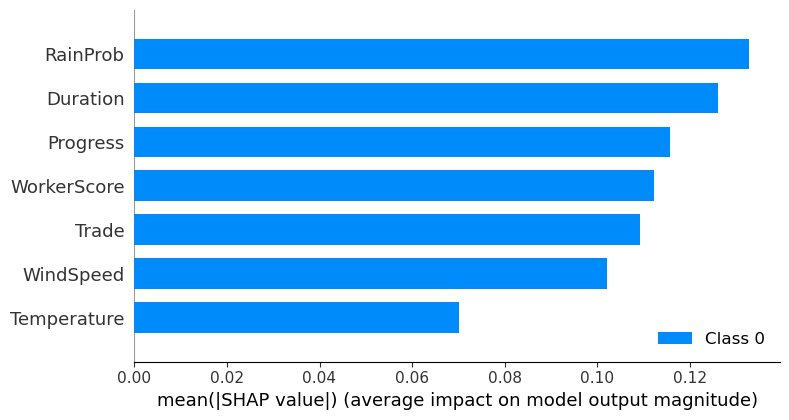

MAE Train: 0.8379313251409763, MAE Validation: 1.1831752535824975


In [22]:
def build_model(hp, input_shape):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units1', min_value=32, max_value=512, step=32), 
                   input_shape=(input_shape, 1), 
                   activation='relu', 
                   return_sequences=True))
    model.add(LSTM(units=hp.Int('units2', min_value=32, max_value=512, step=32), 
                   activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

def train_model(df, target, background_data):
    X = df.drop(columns=[target])
    y = df[target]
    
    # Reshape the input for LSTM
    X = np.expand_dims(X.values, axis=2)
    background_data = np.expand_dims(background_data.values, axis=2)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    input_shape = X_train.shape[1]

    # Check feature variance
    print("Feature Variance:\n", X_train.var(axis=0))

    # Hyperparameter tuning
    tuner = kt.RandomSearch(
        lambda hp: build_model(hp, input_shape=input_shape),
        objective='val_loss',
        max_trials=5,
        executions_per_trial=3,
        directory='my_dir',
        project_name='LSTM_tuning'
    )

    tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)

    # Get the best model
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.hypermodel.build(best_hps)
    history = best_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=20, verbose=0)

    y_val_pred = best_model.predict(X_test)
    y_train_pred = best_model.predict(X_train)

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_val = mean_absolute_error(y_test, y_val_pred)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)

    print(f"MAE Train: {mae_train}, MAE Validation: {mae_val}")
    print(f"RMSE: {rmse_train}, R2: {r2_train}")

    # Use KernelExplainer for the LSTM model
    def model_predict(data):
        return best_model.predict(np.expand_dims(data, axis=2))
    
    explainer = shap.KernelExplainer(model_predict, background_data.squeeze(axis=2))
    shap_values = explainer.shap_values(X_test.squeeze(axis=2), nsamples=100)

    # Inspect the shape of SHAP values without squeezing first
    print("SHAP Values Shape before squeezing:", np.array(shap_values).shape)

    # Reshape the SHAP values if necessary
    if len(shap_values) == len(X_test.squeeze(axis=2)):
        shap_values = np.array(shap_values)

    # Create DataFrame for plotting
    X_test_df = pd.DataFrame(X_test.squeeze(axis=2), columns=df.drop(columns=[target]).columns)
    print("X_test DataFrame Shape:", X_test_df.shape)

    shap.summary_plot(
        shap_values, 
        X_test_df, 
        plot_type="bar", 
        feature_names=df.drop(columns=[target]).columns,
    )

    # Save the best model using joblib
    joblib.dump(best_model, './model/LSTM_v7.pkl')
    
    return best_model, explainer, mae_train, mae_val

processed_df = preprocess_project(df2)
train_df = processed_df.drop(columns=['ID', 'Outline_Number','Name','StartDate','EndDate', 'Predecessors', 'Successors', 'ActualStartDate','ActualEndDate'])
background_data = train_df.drop(columns=['Delay']).sample(n=100, random_state=42)
background_data.to_csv("./data/New_Dummy/background_data.csv")
# print(train_df.columns)

model, explainer, mae_train, mae_val = train_model(train_df, 'Delay', background_data)

print(f"MAE Train: {mae_train}, MAE Validation: {mae_val}")

## Ensemble Model

In [4]:
def get_test_split(df, target):
    X = df.drop(columns=[target])
    y = df[target]

    # Reshape the input for Deep Learning model
    # X = np.expand_dims(X.values, axis=2)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

processed_df = preprocess_project(df2)
train_df = processed_df.drop(columns=['ID', 'Outline_Number','Name','StartDate','EndDate', 'Predecessors', 'Successors', 'ActualStartDate','ActualEndDate'])

X_train, X_test, y_train, y_test = get_test_split(train_df, 'Delay')

#import base models
RF_model = joblib.load("./model/30_2019_v6_RF.pkl")
DT_model = joblib.load("./model/30_2019_v6_DT.pkl")
XGB_model = joblib.load("./model/30_2019_v6_XGB.pkl")
MLP_model = joblib.load("./model/30_2019_v6_MLP.pkl")
CNN_model = joblib.load("./model/30_2019_v6_CNN.pkl")
LSTM_model = joblib.load("./model/30_2019_v6_LSTM.pkl")

MLP_model_reg = KerasRegressor(model=MLP_model, epochs=1, batch_size=20, verbose=0)
CNN_model_reg = KerasRegressor(model=CNN_model, epochs=1, batch_size=20, verbose=0)
LSTM_model_reg = KerasRegressor(model=LSTM_model, epochs=1, batch_size=20, verbose=0)

from sklearn.ensemble import VotingRegressor

# Ensemble model (Voting Regressor)
ensemble_model = VotingRegressor(estimators=[
    ('CNN', CNN_model_reg),
    # ('DT', DT_model),
    ('LSTM', LSTM_model_reg)
    # ('MLP', MLP_model_reg),
    # ('RF', RF_model),
    # ('XGB', XGB_model)
])

ensemble_model.fit(X_train, y_train)

# Now you can use the ensemble model to make predictions
ensemble_predictions = ensemble_model.predict(X_test)


# Stacking models
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# Define the meta-model
meta_model = LinearRegression()

# Create the stacking regressor
stacking_model = StackingRegressor(
    estimators=[
        ('CNN', CNN_model_reg),
        # ('DT', DT_model),
        ('LSTM', LSTM_model_reg)
        # ('MLP', MLP_model_reg),
        # ('RF', RF_model),
        # ('XGB', XGB_model)
    ],
    final_estimator=meta_model
)

# Train the stacking model
stacking_model.fit(X_train, y_train)  # Replace X_train and y_train with your data

# Make predictions
stacking_predictions = stacking_model.predict(X_test)


#Blending Models
# Split your training data into training and validation sets
X_train_blend, X_val_blend, y_train_blend, y_val_blend = train_test_split(X_train, y_train, test_size=0.2)

# Fit each model on the training set
CNN_model_reg.fit(X_train_blend, y_train_blend)
LSTM_model_reg.fit(X_train_blend, y_train_blend)
MLP_model_reg.fit(X_train_blend, y_train_blend)

# Predict on the validation set
cnn_val_pred = CNN_model_reg.predict(X_val_blend)
# dt_val_pred = DT_model.predict(X_val_blend)
lstm_val_pred = LSTM_model_reg.predict(X_val_blend)
# mlp_val_pred = MLP_model_reg.predict(X_val_blend)
# rf_val_pred = RF_model.predict(X_val_blend)
# xgb_val_pred = XGB_model.predict(X_val_blend)

# Create a new dataset with the predictions for the meta-model
# X_meta = np.column_stack((cnn_val_pred, dt_val_pred, lstm_val_pred, mlp_val_pred, rf_val_pred, xgb_val_pred))
X_meta = np.column_stack((cnn_val_pred, lstm_val_pred))

# Train the meta-model on the validation predictions
meta_model.fit(X_meta, y_val_blend)

# Predict on the test set using the base models
cnn_test_pred = CNN_model_reg.predict(X_test)
# dt_test_pred = DT_model.predict(X_test)
lstm_test_pred = LSTM_model_reg.predict(X_test)
# mlp_test_pred = MLP_model_reg.predict(X_test)
# rf_test_pred = RF_model.predict(X_test)
# xgb_test_pred = XGB_model.predict(X_test)

# Combine the test set predictions into a single dataset
# X_test_meta = np.column_stack((cnn_test_pred, dt_test_pred, lstm_test_pred, mlp_test_pred, rf_test_pred, xgb_test_pred))
X_test_meta = np.column_stack((cnn_test_pred, lstm_test_pred))

# Make the final prediction with the meta-model
blending_predictions = meta_model.predict(X_test_meta)

# Calculate metrics
mae_ensemble = mean_absolute_error(y_test, ensemble_predictions) 
mse_ensemble = mean_squared_error(y_test, ensemble_predictions)
rmse_ensemble = np.sqrt(mse_ensemble)
r2_ensemble = r2_score(y_test, ensemble_predictions)

mae_stacking = mean_absolute_error(y_test, stacking_predictions) 
mse_stacking = mean_squared_error(y_test, stacking_predictions)
rmse_stacking = np.sqrt(mse_stacking)
r2_stacking = r2_score(y_test, stacking_predictions)

mae_blending = mean_absolute_error(y_test, blending_predictions) 
mse_blending = mean_squared_error(y_test, blending_predictions)
rmse_blending = np.sqrt(mse_blending)
r2_blending = r2_score(y_test, blending_predictions)

print(f"Voting Regression")
print(f'MAE: {mae_ensemble}')
print(f'RMSE: {rmse_ensemble}')
print(f'R²: {r2_ensemble}\n')

print(f"Stacking")
print(f'MAE: {mae_stacking}')
print(f'RMSE: {rmse_stacking}')
print(f'R²: {r2_stacking}\n')

print(f"Blending")
print(f'MAE: {mae_blending}')
print(f'RMSE: {rmse_blending}')
print(f'R²: {r2_blending}')



INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpb0vwnsdo\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpb0vwnsdo\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpm8kcmd91\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpm8kcmd91\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpojgz4n_x\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpojgz4n_x\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpw4usumqq\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpw4usumqq\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmptjoq492t\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmptjoq492t\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpqprzuvt7\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpqprzuvt7\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmp8_q7uxql\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmp8_q7uxql\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmph5ozy1a7\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmph5ozy1a7\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpnueoqyvb\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpnueoqyvb\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmph4j8ytpw\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmph4j8ytpw\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmphthiyilh\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmphthiyilh\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpk0qgd0y3\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpk0qgd0y3\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpfjse9dax\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpfjse9dax\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpgwkbtymg\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpgwkbtymg\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpn6w2i9qi\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpn6w2i9qi\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmprw8oh5nw\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmprw8oh5nw\assets


Voting Regression
MAE: 1.1820997027059397
RMSE: 1.480917509629929
R²: -0.20023897896373954

Stacking
MAE: 1.286744056281944
RMSE: 1.598475970934138
R²: -0.39835749657250585

Blending
MAE: 1.2178765968978404
RMSE: 1.5244954136953919
R²: -0.2719154275379627


In [25]:
#Choose the best ensemble method

## Save the ensemble model
joblib.dump(ensemble_model, './model/EM_V7.pkl')

INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpvbhe2tlg\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmpvbhe2tlg\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmp5jln3y5o\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmp5jln3y5o\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmplgee586y\assets


INFO:tensorflow:Assets written to: C:\Users\radik\AppData\Local\Temp\tmplgee586y\assets


['./model/EM_V7.pkl']

## Incremental Learning

In [ ]:

process_df_IL1 = df_IL1.drop(columns=['ID', 'Outline_Number','Name','Start_Date', 'Finish_Date', 'Predecessors', 'Successors', 'Actual_Start','Actual_End'])
process_df_IL2 = df_IL2.drop(columns=['ID', 'Outline_Number','Name','Start_Date', 'Finish_Date', 'Predecessors', 'Successors', 'Actual_Start','Actual_End'])
process_df_IL3 = df_IL3.drop(columns=['ID', 'Outline_Number','Name','Start_Date', 'Finish_Date', 'Predecessors', 'Successors', 'Actual_Start','Actual_End'])
process_df_IL4 = df_IL4.drop(columns=['ID', 'Outline_Number','Name','Start_Date', 'Finish_Date', 'Predecessors', 'Successors', 'Actual_Start','Actual_End'])
process_df_IL5 = df_IL5.drop(columns=['ID', 'Outline_Number','Name','Start_Date', 'Finish_Date', 'Predecessors', 'Successors', 'Actual_Start','Actual_End'])

train_df_IL1 = preprocess_project2(process_df_IL1)
train_df_IL2 = preprocess_project2(process_df_IL2)
train_df_IL3 = preprocess_project2(process_df_IL3)
train_df_IL4 = preprocess_project2(process_df_IL4)
train_df_IL5 = preprocess_project2(process_df_IL5)

ensemble_model = joblib.load('./model/EM_V7.pkl')

def update_ensemble_with_data(ensemble_model, train_df):
    X = train_df.drop(columns=['Delay'])
    y = train_df['Delay']
    
    # Assuming individual models in the ensemble support partial_fit
    for name, model in ensemble_model.named_estimators_.items():
        if hasattr(model, 'partial_fit'):
            model.partial_fit(X, y)
        else:
            model.fit(X, y)
    
    return ensemble_model

# Apply incremental learning across all datasets
for train_df in [train_df_IL1, train_df_IL2, train_df_IL3, train_df_IL4, train_df_IL5]:
    ensemble_model = update_ensemble_with_data(ensemble_model, train_df)

# Assume X_test and y_test are already defined
final_predictions = ensemble_model.predict(X_test)

# Evaluate the final model performance
mae_final = mean_absolute_error(y_test, final_predictions)
mse_final = mean_squared_error(y_test, final_predictions)
rmse_final = np.sqrt(mse_final)
r2_final = r2_score(y_test, final_predictions)

print(f"Final Model After Incremental Learning")
print(f'MAE: {mae_final}')
print(f'RMSE: {rmse_final}')
print(f'R²: {r2_final}')


## Save the ensemble model
joblib.dump(ensemble_model, './model/ILM_V7.pkl')


In [ ]:
model = joblib.load("./model/ILM_V7.pkl")

class VotingRegressorWrapper:
    def __init__(self, voting_regressor):
        self.voting_regressor = voting_regressor

    def predict(self, X):
        # This returns the ensemble prediction
        return self.voting_regressor.predict(X)

# Wrap the VotingRegressor
wrapped_model = VotingRegressorWrapper(model)

# Now use KernelExplainer with the wrapped model
explainer = shap.KernelExplainer(wrapped_model.predict, X_test)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X_test.columns)

In [8]:
#Experiment
import pandas as pd

# Load the dataset
data = pd.read_excel('./data/New_Dummy/Project Dummy Data - Progressive.xlsx', sheet_name='Progress 100%')

# Create a new column 'Dates_Match' to indicate if Start_Date and Actual_Start are the same
data['Dates_Match'] = data['Start_Date'] == data['Actual_Start']

# To display the columns of interest
comparison_results = data[['Start_Date', 'Actual_Start', 'Dates_Match']]
print(comparison_results[comparison_results['Dates_Match'] == False])

Empty DataFrame
Columns: [Start_Date, Actual_Start, Dates_Match]
Index: []


In [3]:
import pandas as pd
from collections import defaultdict, deque

# Load the file
file_path = './test/project_prediction_processed.csv'
data = pd.read_csv(file_path)

# Ensure the Predecessor column is properly formatted as a list of integers
data['Predecessor'] = data['Predecessor'].apply(lambda x: [int(i) for i in str(x).split(',')] if x != '0' else [])

# Create a graph of tasks and their dependencies
def build_graph(data):
    graph = defaultdict(list)
    indegree = defaultdict(int)
    
    # Build the graph and indegree count
    for index, row in data.iterrows():
        task_id = row['Id']
        if row['Predecessor']:
            for pre_id in row['Predecessor']:
                graph[pre_id].append(task_id)
                indegree[task_id] += 1
        else:
            indegree[task_id]  # Ensure tasks with no predecessors are tracked
    
    return graph, indegree

# Perform topological sort (Kahn's algorithm)
def topological_sort(graph, indegree):
    zero_indegree_queue = deque([task for task in indegree if indegree[task] == 0])
    sorted_tasks = []
    
    while zero_indegree_queue:
        task = zero_indegree_queue.popleft()
        sorted_tasks.append(task)
        
        for successor in graph[task]:
            indegree[successor] -= 1
            if indegree[successor] == 0:
                zero_indegree_queue.append(successor)
    
    return sorted_tasks

# Build the task graph and calculate indegrees
graph, indegree = build_graph(data)

# Get the topologically sorted tasks
sorted_tasks = topological_sort(graph, indegree)

# Initialize task delays
task_delays = {}

# Process tasks in topological order to calculate delays
for task_id in sorted_tasks:
    task_row = data[data['Id'] == task_id].iloc[0]
    predecessors = task_row['Predecessor']
    
    # Calculate start delay from predecessors
    if predecessors:
        # Get the maximum delay among the predecessors
        predecessor_delays = [task_delays[pre_id] for pre_id in predecessors]
        start_delay = max(predecessor_delays) if predecessor_delays else 0
    else:
        start_delay = 0
    
    # Total delay is the start delay plus the task's own prediction delay
    task_delays[task_id] = start_delay + task_row['Prediction']

# The total project delay is the maximum delay among all tasks
total_project_delay = max(task_delays.values())

# Output the total delay
print(f'Total Project Delay: {total_project_delay} days')

Total Project Delay: 11 days


In [1]:
import pandas as pd
import ast 

df = pd.read_csv('./test/predictions_output_LSTM.csv')

def calculate_shap_average(df):
    # Convert the SHAP_score column from string representation of dictionary to actual dictionary
    df['SHAP_score'] = df['SHAP_score'].apply(ast.literal_eval)

    # Create a new DataFrame to store SHAP values for each feature
    shap_df = pd.json_normalize(df['SHAP_score'])

    # Calculate the mean SHAP score for each feature
    mean_shap_scores = shap_df.mean()

    # Display the mean SHAP scores
    mean_shap_scores

    print(mean_shap_scores)

calculate_shap_average(df)

Duration       0.150540
Trade          0.024050
Progress       0.025238
WorkerScore    0.057697
Temperature    0.143674
RainProb       0.089950
WindSpeed     -0.127528
dtype: float64
